# Synthetic Brand Generation V2 - Enhanced with Ensemble Methods

### University of Colorado Boulder - CSCA 5642: Introduction to Deep Learning
---
#### Dyego Fernandes de Sousa
---

## Problem Statement

To showcase and demonstrate the application of **Generative Deep Learning** techniques for synthesizing realistic tabular data with associated text fields.

This project is a continuation of my previous works on **Supervised Learning** and **Unsupervised Learning**, you can find more information in the appendix.

### Dataset Overview:
Detailed ESG (Environmenta Social and Governance) dataset to the brand-level
Observations: 3605
Features: 77

### Deliverables

1. **Generative Adversarial Networks (GANs)**: Implement and train CTGAN for mixed-type tabular data
2. **Variational Autoencoders (VAEs)**: Apply TVAE as an alternative generative approach
3. **Statistical Methods**: Integrate Gaussian Copula for correlation structure preservation
4. **Large Language Models (LLMs)**: Fine-tune GPT-2 and Flan-T5 for conditional text generation
5. **Ensemble Methods**: Combine multiple generators with optimized weighting
6. **Evaluation Metrics**: Apply statistical tests (KS, correlation) to assess synthetic data quality


## ML Approach & Architecture

The following diagram illustrates the complete pipeline for synthetic brand data generation:

### Deep Learning Models Used

| Model | Type | Purpose | Key Features |
|-------|------|---------|-------------|
| **CTGAN** | Conditional GAN | Tabular synthesis | Mode-specific normalization, conditional vector |
| **TVAE** | Variational Autoencoder | Distribution learning | KL divergence, latent space regularization |
| **Gaussian Copula** | Statistical | Correlation preservation | Multivariate dependencies |
| **GPT-2 Medium** | Transformer LLM | Brand name generation | 355M params, fine-tuned |
| **Flan-T5 Small** | Encoder-Decoder | Conditional text gen | Instruction-following |

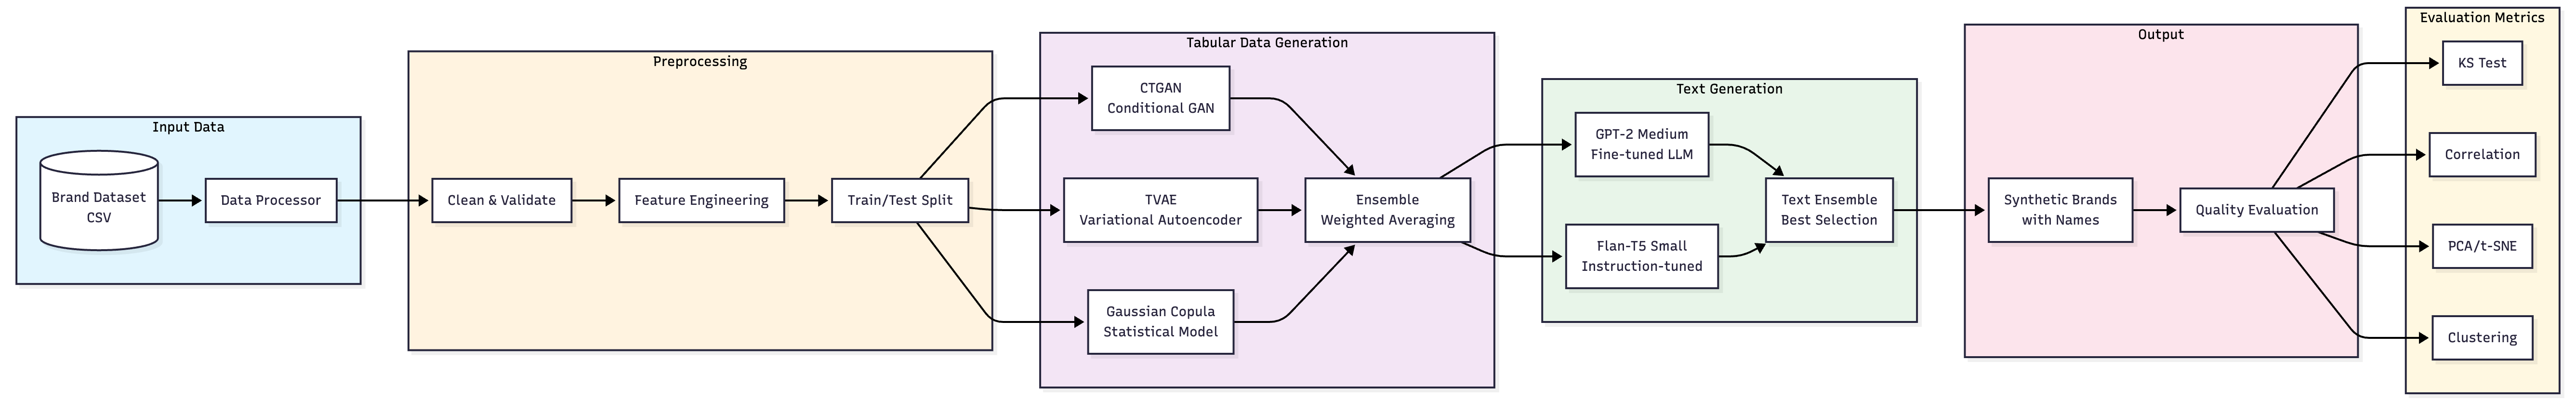

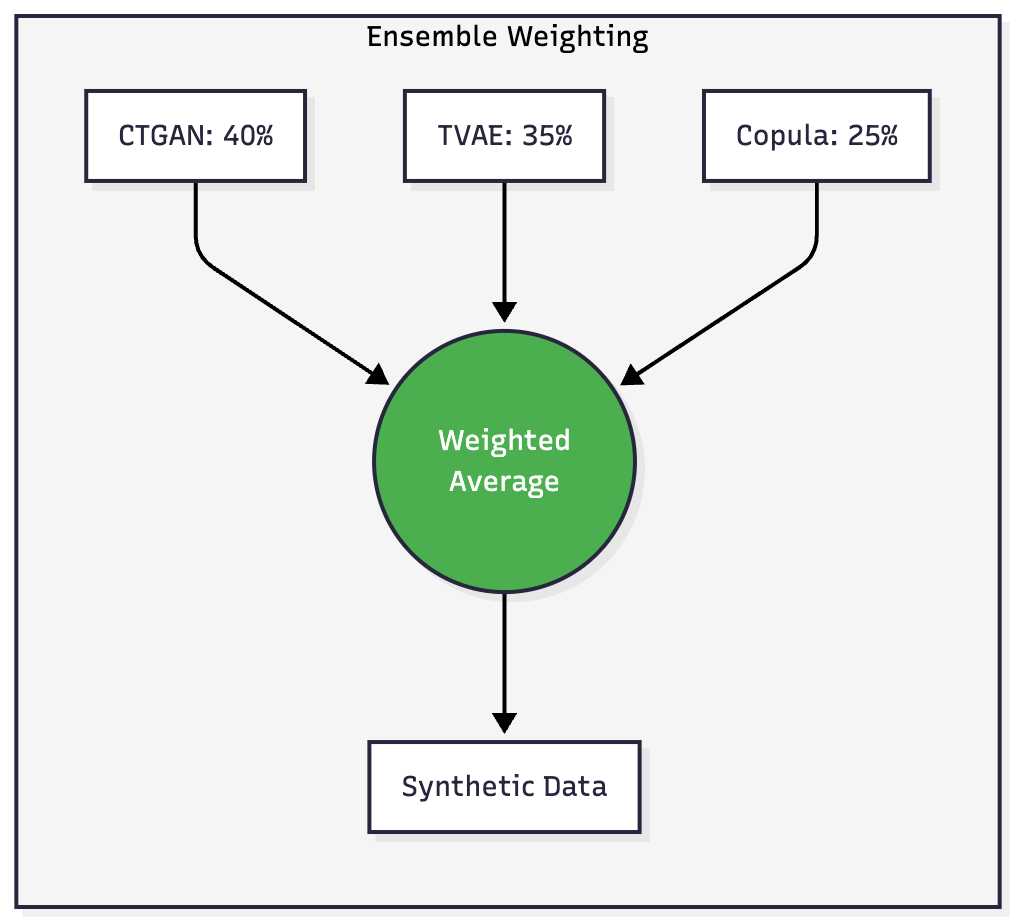

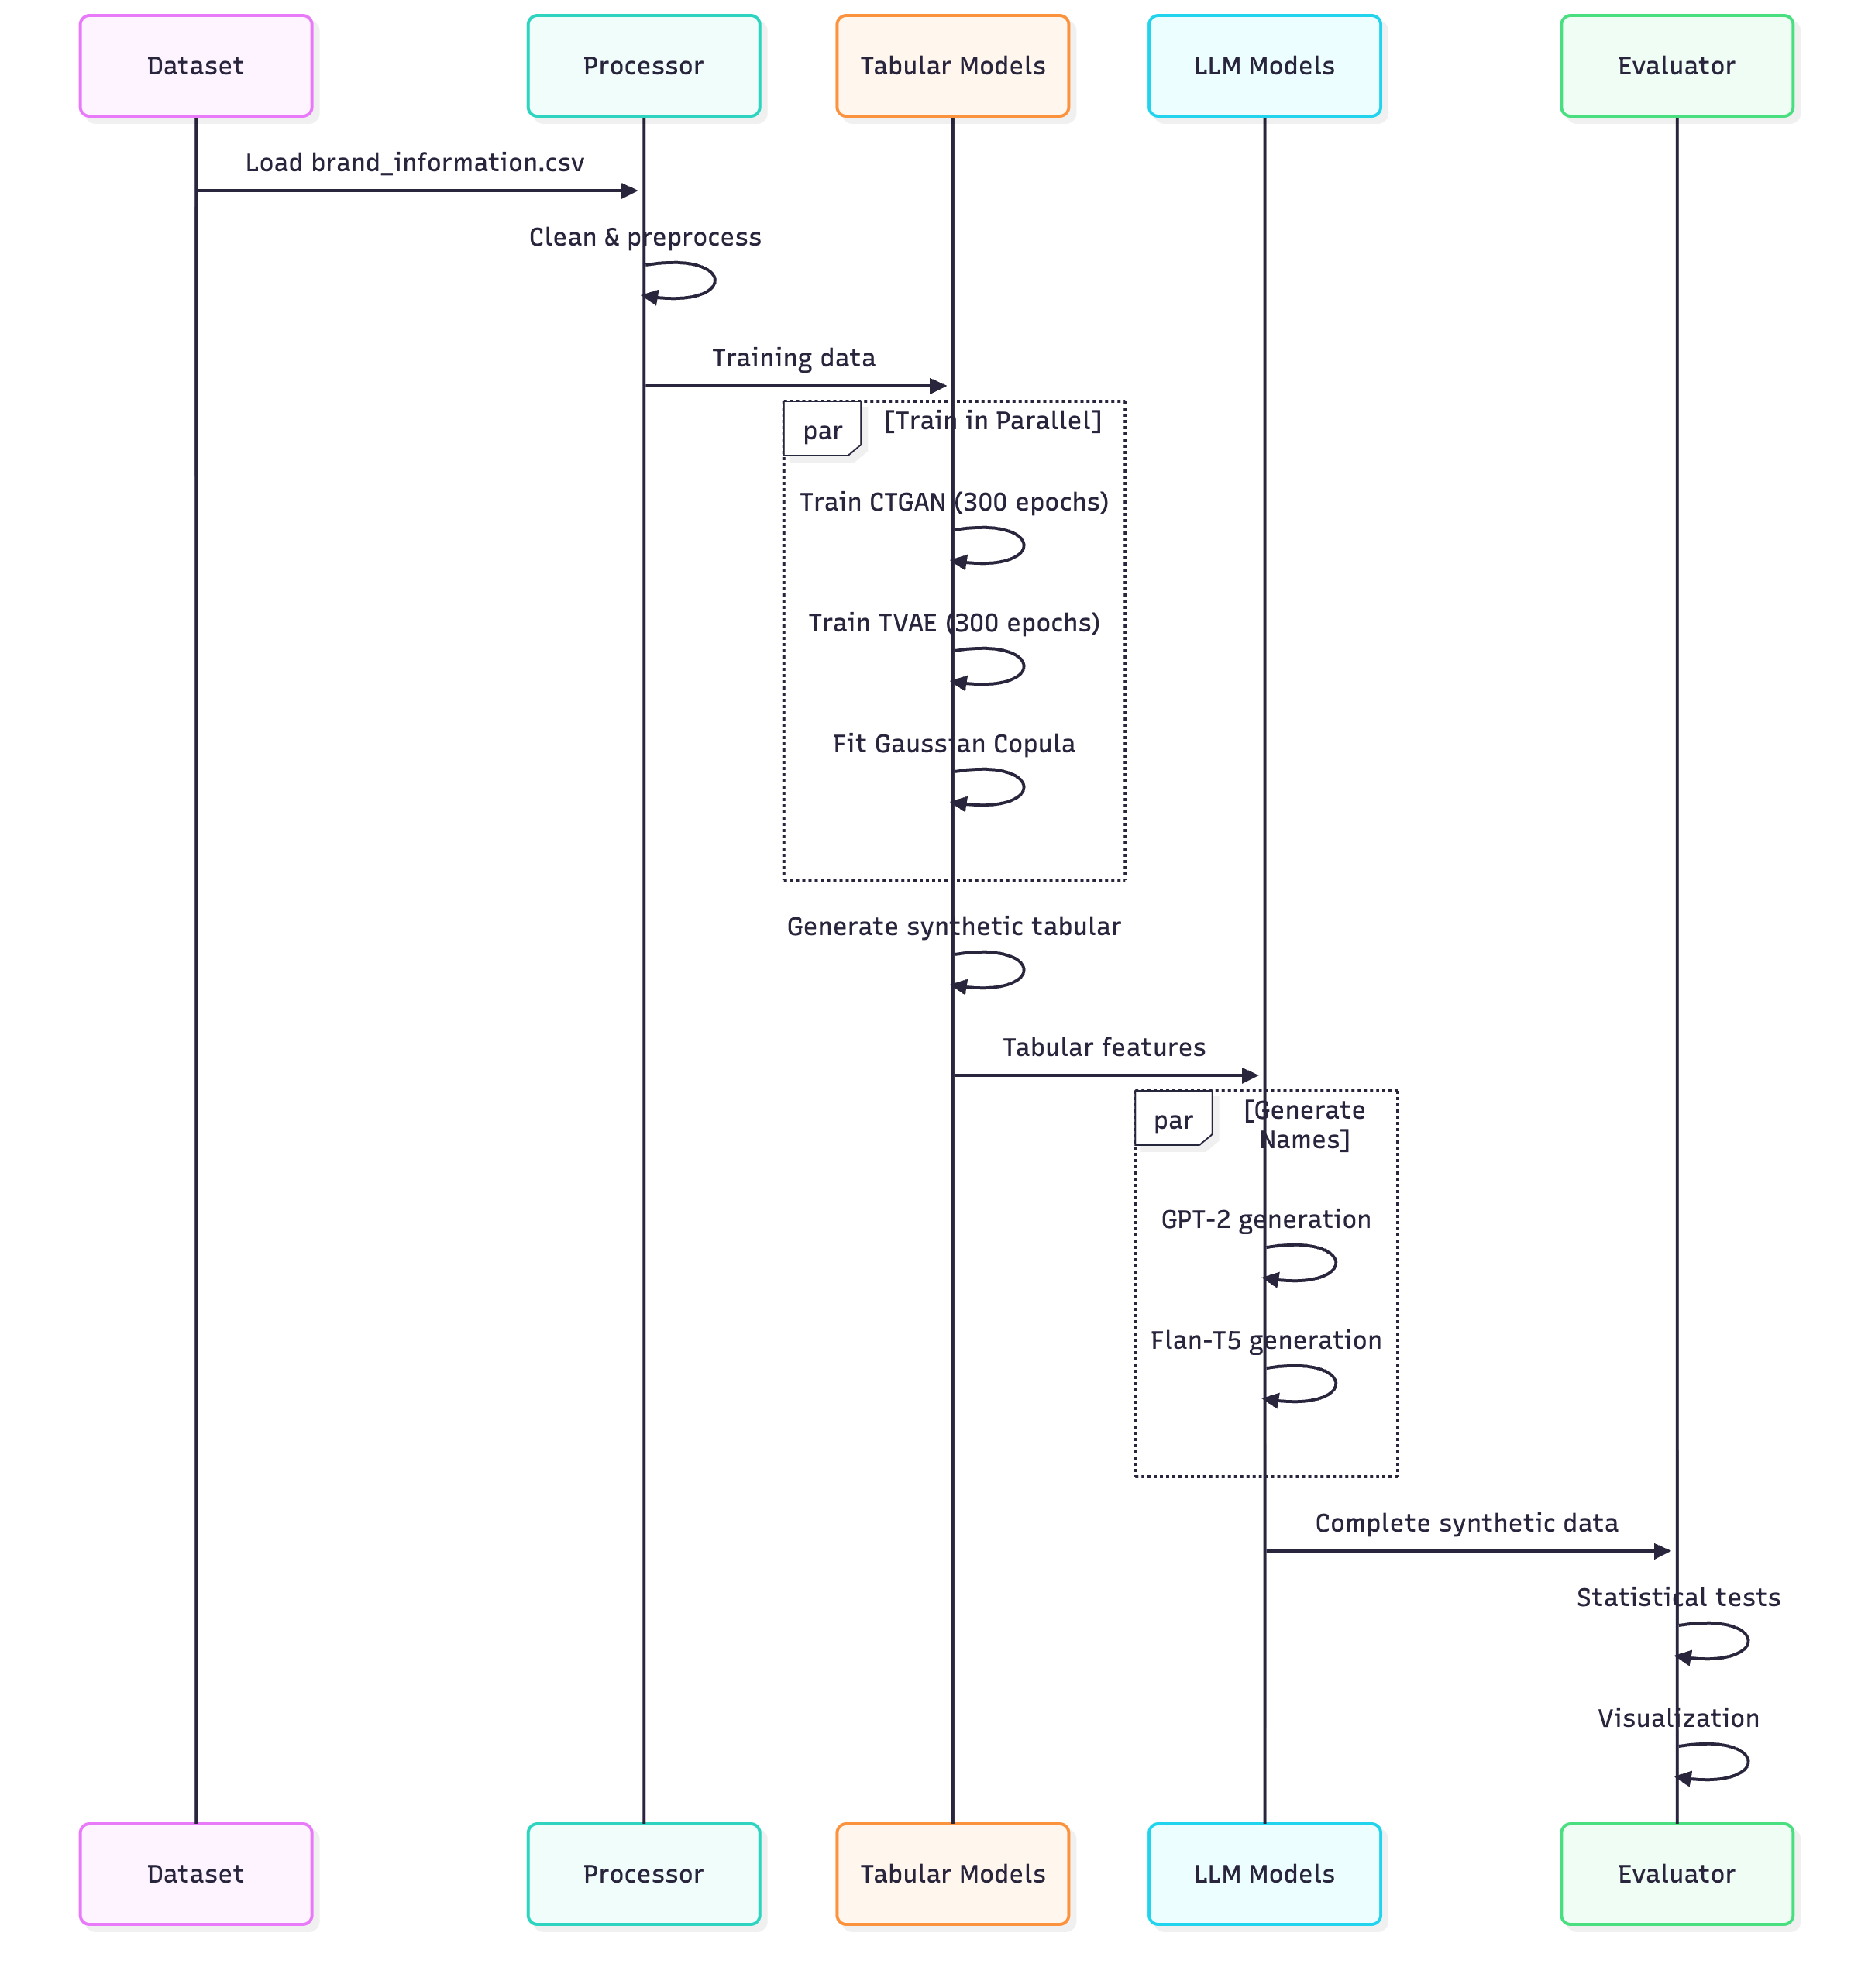

## Phase 1: Setup & Installation

### Optimized for Google Colab Pro (~15GB RAM, ~16GB VRAM)

In [1]:
# Clone repository and install dependencies
!git clone https://github.com/dyegofern/csca5642-deep-learning.git
!pip install -q sdv transformers torch pandas numpy scikit-learn matplotlib seaborn plotly scipy
!pip install -q peft bitsandbytes accelerate sentencepiece
!pip install -q optuna

import sys
import os
from google.colab import drive

MAPPED_DIR = '/content/csca5642-deep-learning'

# Mount Google Drive
print("Mounting Google Drive...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

DATA_PATH = MAPPED_DIR + '/data/raw/brand_information.csv'

# Set output and model directories to Google Drive
DRIVE_OUTPUT_BASE = '/content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2'
OUTPUT_DIR = os.path.join(DRIVE_OUTPUT_BASE, 'outputs')
MODEL_DIR = os.path.join(DRIVE_OUTPUT_BASE, 'models')

# Create directories
print(f"\nCreating directories in Google Drive...")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

# Add src to path
src_path = MAPPED_DIR + '/src'
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"\nSetup complete!")

Cloning into 'csca5642-deep-learning'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 94 (delta 50), reused 65 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 1.55 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (50/50), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.3/197.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [2]:
# Import V2 modules
from data_processor import BrandDataProcessor
from tabular_gan_v2 import (
    EnsembleSynthesizer,
    CTGANSynthesizerWrapper,
    TVAESynthesizerWrapper,
    GaussianCopulaSynthesizerWrapper,
    calculate_generation_targets
)
from brand_name_generator_v2 import BrandNameGeneratorV2
from evaluator import BrandDataEvaluator

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Check GPU
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("\nAll V2 modules loaded successfully!")

CUDA available: True
GPU: NVIDIA L4
Memory: 23.8 GB

All V2 modules loaded successfully!


## Configuration

In [3]:
# Configuration for V2
FROM_PRETRAINED = False  # Set to True to load pre-trained models

# Tabular Ensemble Config
CTGAN_EPOCHS = 300
TVAE_EPOCHS = 300
BATCH_SIZE = 500
ENSEMBLE_WEIGHTS = {
    'ctgan': 0.40,
    'tvae': 0.35,
    'gaussian_copula': 0.25
}

# LLM Ensemble Config
LLM_MODELS = ['gpt2-medium', 'flan-t5-base']  # Can add 'phi-2', 'tinyllama' if memory allows
LLM_EPOCHS = 3

# Generation Config
MIN_BRANDS_PER_COMPANY = 10
DIVERSITY_TEMPERATURE = 0.7
ADD_DIVERSITY_NOISE = True

print("Configuration:")
print(f"  FROM_PRETRAINED: {FROM_PRETRAINED}")
print(f"  CTGAN_EPOCHS: {CTGAN_EPOCHS}")
print(f"  TVAE_EPOCHS: {TVAE_EPOCHS}")
print(f"  LLM_MODELS: {LLM_MODELS}")
print(f"  ENSEMBLE_WEIGHTS: {ENSEMBLE_WEIGHTS}")

Configuration:
  FROM_PRETRAINED: False
  CTGAN_EPOCHS: 300
  TVAE_EPOCHS: 300
  LLM_MODELS: ['gpt2-medium', 'flan-t5-base']
  ENSEMBLE_WEIGHTS: {'ctgan': 0.4, 'tvae': 0.35, 'gaussian_copula': 0.25}


## Phase 0: Hyperparameter Tuning (Optional)

This phase uses Optuna to find optimal hyperparameters for the tabular synthesizers.
Set `RUN_HYPERPARAMETER_TUNING = True` to run optimization, or use previously saved best parameters.

**Tuned Parameters:**
- **CTGAN/TVAE**: epochs, batch_size, embedding_dim, generator/discriminator dimensions
- **Ensemble**: weights for each model
- **Generation**: noise_level, diversity_temperature

In [4]:
# Hyperparameter Tuning Configuration
RUN_HYPERPARAMETER_TUNING = True  # Set to True to run Optuna optimization
N_TUNING_TRIALS = 20  # Number of Optuna trials (more = better but slower)
TUNING_TIMEOUT = 300  # Maximum time for tuning in seconds (60 minutes)

# Path to save/load best hyperparameters
HYPERPARAMS_PATH = os.path.join(MODEL_DIR, 'best_hyperparameters.json')

print(f"Hyperparameter tuning: {'ENABLED' if RUN_HYPERPARAMETER_TUNING else 'DISABLED'}")
print(f"Trials: {N_TUNING_TRIALS}, Timeout: {TUNING_TIMEOUT}s")
print(f"Hyperparameters path: {HYPERPARAMS_PATH}")

Hyperparameter tuning: ENABLED
Trials: 20, Timeout: 900s
Hyperparameters path: /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/best_hyperparameters.json


In [5]:
# Import hyperparameter tuner from external module
from hyperparameter_tuner_v2 import HyperparameterTunerV2

# Initialize tuner (will be used after data preparation)
tuner = None
best_hyperparams = None

print("HyperparameterTunerV2 imported successfully.")
print("Tuner will be initialized after data preparation (Phase 1).")

HyperparameterTunerV2 imported successfully.
Tuner will be initialized after data preparation (Phase 1).


In [6]:
# Check for saved hyperparameters
if os.path.exists(HYPERPARAMS_PATH):
    print("Found saved hyperparameters!")
    best_hyperparams = HyperparameterTunerV2.load(HYPERPARAMS_PATH)

    print(f"Previous best score: {best_hyperparams.get('best_score', 'N/A')}")
    print(f"Trials completed: {best_hyperparams.get('n_trials', 'N/A')}")
    print(f"Timestamp: {best_hyperparams.get('tuning_timestamp', 'N/A')}")

    # Update configuration with loaded hyperparameters
    CTGAN_EPOCHS = best_hyperparams.get('ctgan_epochs', CTGAN_EPOCHS)
    TVAE_EPOCHS = best_hyperparams.get('tvae_epochs', TVAE_EPOCHS)
    BATCH_SIZE = best_hyperparams.get('batch_size', BATCH_SIZE)
    if 'ensemble_weights' in best_hyperparams:
        ENSEMBLE_WEIGHTS = best_hyperparams['ensemble_weights']

    print(f"\nUsing optimized configuration:")
    print(f"  CTGAN_EPOCHS: {CTGAN_EPOCHS}")
    print(f"  TVAE_EPOCHS: {TVAE_EPOCHS}")
    print(f"  BATCH_SIZE: {BATCH_SIZE}")
    print(f"  ENSEMBLE_WEIGHTS: {ENSEMBLE_WEIGHTS}")
else:
    print("No saved hyperparameters found.")
    if RUN_HYPERPARAMETER_TUNING:
        print("Hyperparameter tuning will run after data preparation.")
    else:
        print("Using default configuration. Set RUN_HYPERPARAMETER_TUNING=True to optimize.")

No saved hyperparameters found.
Hyperparameter tuning will run after data preparation.


## Phase 1: Data Preparation

In [7]:
# Load and process data
processor = BrandDataProcessor(DATA_PATH)
raw_data = processor.load_data()
print(f"Loaded {len(raw_data)} brands with {len(raw_data.columns)} features")

Loading data from /content/csca5642-deep-learning/data/raw/brand_information.csv...
Loaded 3605 brands with 77 features
Loaded 3605 brands with 77 features


In [8]:
# Clean data
cleaned_data = processor.clean_data()
print(f"\nCleaned data: {len(cleaned_data)} rows, {len(cleaned_data.columns)} columns")


=== Data Cleaning ===

Identified 54 numerical features
Identified 7 categorical features
Identified 6 text features (will be handled separately)
Dropped text-heavy columns: ['esg_summary', 'accusation', 'references_and_links']

Handling missing values...
  Filled demographics_gender with mode/Unknown
  Filled demographics_lifestyle with mode/Unknown

Cleaned dataset: 3605 rows, 74 columns

Cleaned data: 3605 rows, 74 columns


In [9]:
# Prepare for GAN training
train_df, val_df = processor.prepare_for_gan(test_size=0.2)

print(f"\nTraining set: {len(train_df)} brands")
print(f"Validation set: {len(val_df)} brands")

# Get column types
discrete_cols = processor.categorical_features
binary_cols = [col for col in train_df.columns if train_df[col].nunique() == 2 and set(train_df[col].unique()).issubset({0, 1})]
numerical_cols = [col for col in train_df.columns if col not in discrete_cols and col not in binary_cols]

print(f"\nColumn types:")
print(f"  Numerical: {len(numerical_cols)}")
print(f"  Categorical: {len(discrete_cols)}")
print(f"  Binary: {len(binary_cols)}")


=== Preparing Data for GAN ===

Encoding categorical features...
  Encoded industry_name: 14 unique values
  Encoded country_of_origin: 42 unique values
  Encoded headquarters_country: 43 unique values
  Encoded demographics_income_level: 84 unique values
  Encoded demographics_geographic_reach: 167 unique values
  Encoded demographics_gender: 49 unique values
  Encoded demographics_lifestyle: 3540 unique values
  Encoded company_name: 243 companies
Added 40 single-brand companies to training set.

Train set: 2892 brands
Validation set: 713 brands

Training set: 2892 brands
Validation set: 713 brands

Column types:
  Numerical: 25
  Categorical: 7
  Binary: 30


In [11]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 28.0 MB/s eta 0:00:00


Initializing hyperparameter tuner...
HyperparameterTunerV2 initialized:
  Training samples: 2892
  Eval sample size: 1000
  Numerical columns: 25
  Discrete columns: 7
  Binary columns: 30

HYPERPARAMETER TUNING WITH OPTUNA
Trials: 20
Timeout: 900s
Seed: 42


  0%|          | 0/20 [00:00<?, ?it/s]


BEST HYPERPARAMETERS FOUND
Best score: 0.2403
CTGAN epochs: 500
TVAE epochs: 400
Batch size: 500
Embedding dim: 256
Generator dim: [256, 256]
Discriminator dim: [128, 128]
Ensemble weights: {'ctgan': 0.10779739982922815, 'tvae': 0.5801156372569487, 'gaussian_copula': 0.3120869629138232}
Hyperparameters saved to: /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/best_hyperparameters.json
Plot saved to: /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/outputs/hyperparameter_tuning_history.png


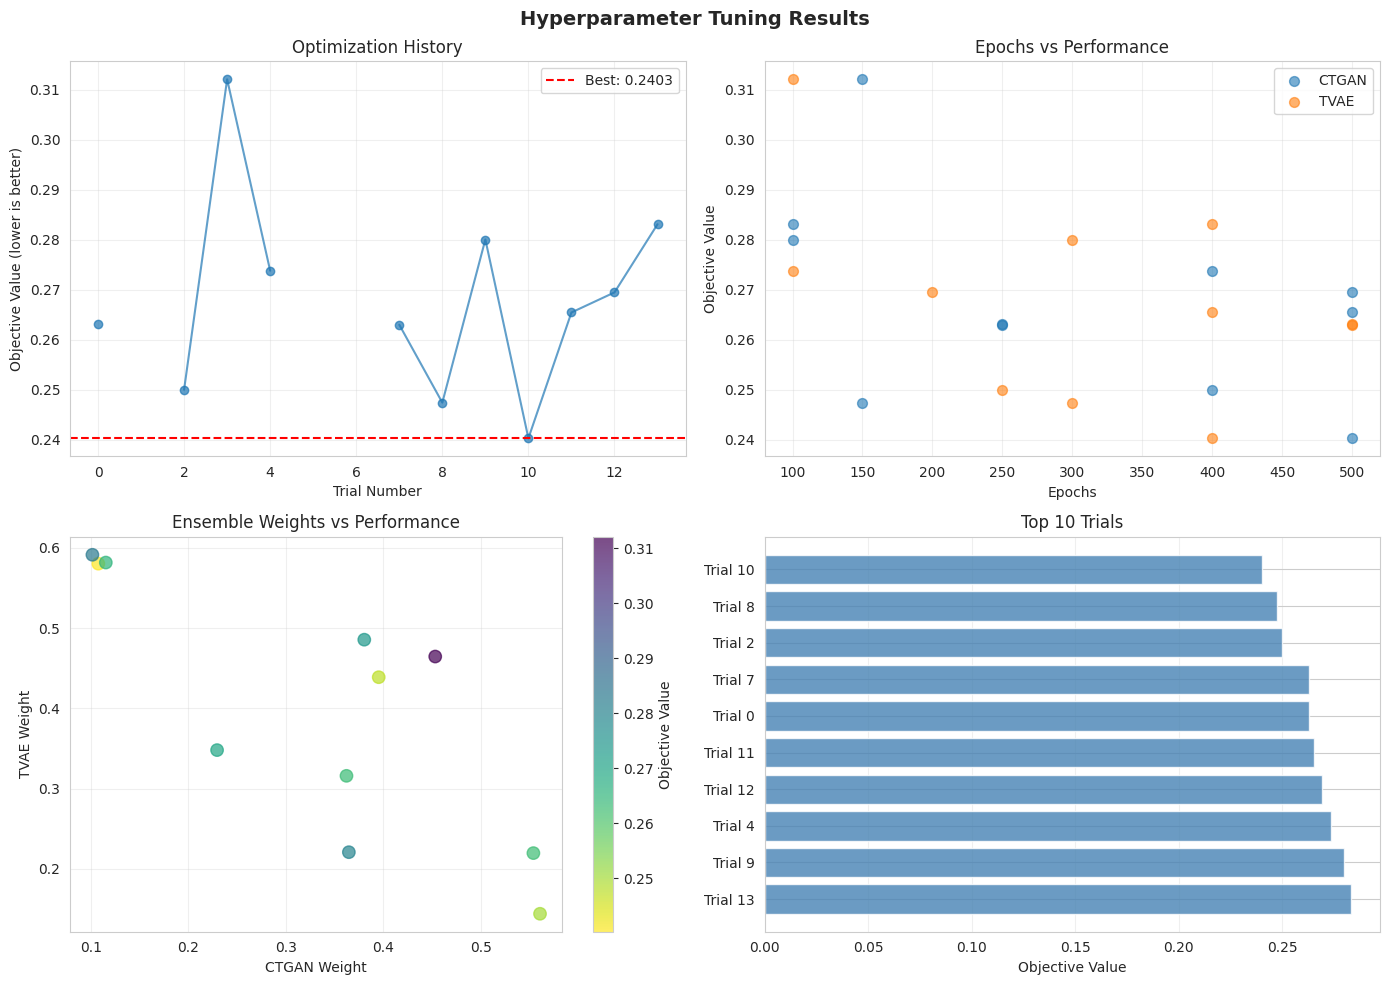


Updated configuration with optimized hyperparameters:
  CTGAN_EPOCHS: 500
  TVAE_EPOCHS: 400
  BATCH_SIZE: 500
  ENSEMBLE_WEIGHTS: {'ctgan': 0.10779739982922815, 'tvae': 0.5801156372569487, 'gaussian_copula': 0.3120869629138232}


In [12]:
# Execute hyperparameter tuning if enabled and no saved params exist
if RUN_HYPERPARAMETER_TUNING and best_hyperparams is None:
    print("Initializing hyperparameter tuner...")

    # Create tuner instance
    tuner = HyperparameterTunerV2(
        train_data=train_df,
        discrete_cols=discrete_cols,
        binary_cols=binary_cols,
        eval_sample_size=min(1000, len(train_df)),
        gen_sample_size=500,
        verbose=True
    )

    # Run optimization
    best_hyperparams = tuner.tune(
        n_trials=N_TUNING_TRIALS,
        timeout=TUNING_TIMEOUT,
        seed=42,
        show_progress_bar=True
    )

    # Save the best hyperparameters
    tuner.save(HYPERPARAMS_PATH)

    # Plot optimization history
    tuner.plot_optimization_history(
        save_path=os.path.join(OUTPUT_DIR, 'hyperparameter_tuning_history.png')
    )

    # Update global configuration
    CTGAN_EPOCHS = best_hyperparams['ctgan_epochs']
    TVAE_EPOCHS = best_hyperparams['tvae_epochs']
    BATCH_SIZE = best_hyperparams['batch_size']
    ENSEMBLE_WEIGHTS = best_hyperparams['ensemble_weights']

    print(f"\nUpdated configuration with optimized hyperparameters:")
    print(f"  CTGAN_EPOCHS: {CTGAN_EPOCHS}")
    print(f"  TVAE_EPOCHS: {TVAE_EPOCHS}")
    print(f"  BATCH_SIZE: {BATCH_SIZE}")
    print(f"  ENSEMBLE_WEIGHTS: {ENSEMBLE_WEIGHTS}")
else:
    if best_hyperparams is not None:
        print("Using previously loaded hyperparameters.")
    else:
        print("Using default hyperparameters. Set RUN_HYPERPARAMETER_TUNING=True to optimize.")

## Phase 2: Tabular Ensemble Training

Training CTGAN, TVAE, and Gaussian Copula models

In [13]:
# Initialize Ensemble Synthesizer
tabular_ensemble = EnsembleSynthesizer(
    ctgan_epochs=CTGAN_EPOCHS,
    ctgan_batch_size=BATCH_SIZE,
    tvae_epochs=TVAE_EPOCHS,
    tvae_batch_size=BATCH_SIZE,
    gc_default_distribution='beta',
    weights=ENSEMBLE_WEIGHTS,
    verbose=True,
    cuda=True
)

print("Tabular Ensemble initialized with:")
print(f"  - CTGAN (epochs={CTGAN_EPOCHS})")
print(f"  - TVAE (epochs={TVAE_EPOCHS})")
print(f"  - Gaussian Copula (distribution=beta)")

Tabular Ensemble initialized with:
  - CTGAN (epochs=500)
  - TVAE (epochs=400)
  - Gaussian Copula (distribution=beta)


In [14]:
if FROM_PRETRAINED:
    # Load pre-trained models
    print("Loading pre-trained tabular ensemble...")
    tabular_ensemble.load_models(os.path.join(MODEL_DIR, 'tabular_ensemble'))
else:
    # Train all models
    print("Training tabular ensemble (this will take ~30-60 minutes)...")
    training_times = tabular_ensemble.train(
        data=train_df,
        discrete_columns=discrete_cols,
        binary_columns=binary_cols
    )

    # Save models
    tabular_ensemble.save_models(os.path.join(MODEL_DIR, 'tabular_ensemble'))

    print(f"\nTraining times:")
    for model, time in training_times.items():
        print(f"  {model}: {time:.1f} seconds")

Training tabular ensemble (this will take ~30-60 minutes)...

ENSEMBLE SYNTHESIZER: TRAINING ALL MODELS
Enabled models: ['ctgan', 'tvae', 'gaussian_copula']

--- Training CTGAN ---

=== Training CTGAN ===
Training on 2892 samples with 62 features
Converting 30 binary columns to boolean...
Setting 30 binary columns as boolean type in metadata...
Training for 500 epochs with batch size 500...


Gen. (-0.48) | Discrim. (-0.90): 100%|██████████| 500/500 [02:50<00:00,  2.93it/s]


CTGAN Training completed!
ctgan trained in 179.90 seconds

--- Training TVAE ---

=== Training TVAE ===
Training on 2892 samples with 62 features
Converting 30 binary columns to boolean...
Setting 30 binary columns as boolean type in metadata...
Training for 400 epochs with batch size 500...


Loss: -113.289: 100%|██████████| 400/400 [01:20<00:00,  4.96it/s]


TVAE Training completed!
tvae trained in 89.65 seconds

--- Training GAUSSIAN_COPULA ---

=== Training Gaussian Copula ===
Training on 2892 samples with 62 features
Converting 30 binary columns to boolean...
Setting 30 binary columns as boolean type in metadata...
Fitting Gaussian Copula with 'beta' distribution...
Gaussian Copula Training completed!
gaussian_copula trained in 7.28 seconds

TRAINING COMPLETE
Total time: 276.83 seconds
CTGAN model saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/tabular_ensemble/ctgan_model.pkl
TVAE model saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/tabular_ensemble/tvae_model.pkl
Gaussian Copula model saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/tabular_ensemble/gaussian_copula_model.pkl
Ensemble models saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/tabular_ensemble

Training times:
  ctgan: 179.9 seconds
  tvae: 89.6 se

In [15]:
# Compare individual model quality
print("Evaluating individual model quality...")
comparison_df = tabular_ensemble.compare_all_models(train_df, n_samples=1000)
print("\nModel Comparison:")
display(comparison_df)

Evaluating individual model quality...

=== Generating 1000 Samples (Ensemble) ===
  Generating from ctgan...
  Generating from tvae...
  Generating from gaussian_copula...
  Combined 1000 samples from 3 models

Model Comparison:


,Mean KS Statistic,KS Pass Rate,Correlation MSE,Mean Relative Error
ctgan,0.285157,0.000000,0.020597,0.546407
tvae,0.129666,0.666667,0.012418,0.369960
gaussian_copula,0.350456,0.222222,0.019653,145.629258
ensemble,0.483732,0.000000,0.011854,43.457037


In [16]:
# Optionally optimize weights based on quality
optimized_weights = tabular_ensemble.optimize_weights(train_df, n_eval_samples=1000)
print(f"Optimized weights: {optimized_weights}")


=== Evaluating Individual Model Quality ===

Evaluating ctgan...
  Mean KS statistic: 0.2865
  Correlation MSE: 0.0237

Evaluating tvae...
  Mean KS statistic: 0.1255
  Correlation MSE: 0.0095

Evaluating gaussian_copula...
  Mean KS statistic: 0.3560
  Correlation MSE: 0.0176

Optimized weights: {'ctgan': np.float64(0.24728746110955518), 'tvae': np.float64(0.5463339523621822), 'gaussian_copula': np.float64(0.2063785865282627)}
Optimized weights: {'ctgan': np.float64(0.24728746110955518), 'tvae': np.float64(0.5463339523621822), 'gaussian_copula': np.float64(0.2063785865282627)}


## Phase 3: LLM Ensemble Training

Training GPT-2 Medium and Flan-T5 for brand name generation

In [17]:
# Prepare brand name training data
brands_df = processor.df[['brand_name', 'company_name', 'industry_name']].dropna()
print(f"Brand name training data: {len(brands_df)} examples")
brands_df.head()

Brand name training data: 3605 examples


,brand_name,company_name,industry_name
0,00 Null Null,"S. C. Johnson & Son, Inc.",Household & Personal Products
1,100 Grand,Ferrero Group,Processed Foods
2,1950 127 Cheese,Foremost Farms USA Cooperative,"Meat, Poultry & Dairy"
3,2nd Street Creamery,"Wells Enterprises, Inc.",Processed Foods
4,3 Musketeers,"Mars, Incorporated",Processed Foods


In [18]:
# Initialize LLM Ensemble Generator
llm_generator = BrandNameGeneratorV2(
    models=LLM_MODELS,
    memory_efficient=True,
    verbose=True
)

print(f"LLM Ensemble initialized with models: {LLM_MODELS}")

LLM Ensemble initialized with models: ['gpt2-medium', 'flan-t5-base']


In [19]:
if FROM_PRETRAINED:
    # Load pre-trained models
    print("Loading pre-trained LLM ensemble...")
    llm_generator.load_model(os.path.join(MODEL_DIR, 'llm_ensemble'))
else:
    # Fine-tune all models
    print(f"Fine-tuning LLM ensemble (epochs={LLM_EPOCHS})...")
    print("This will train each model sequentially to save memory.")

    llm_generator.fine_tune(
        brands_df=brands_df,
        epochs=LLM_EPOCHS,
        output_dir=os.path.join(MODEL_DIR, 'llm_ensemble')
    )

    # Save ensemble config
    llm_generator.save_model(os.path.join(MODEL_DIR, 'llm_ensemble'))

Fine-tuning LLM ensemble (epochs=3)...
This will train each model sequentially to save memory.

FINE-TUNING: gpt2-medium
Loading gpt2-medium...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on cuda

=== Fine-tuning gpt2-medium ===
Training on 3605 examples


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dyegofern (dyegofern-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,2.402700
100,1.387900
150,1.223700
200,1.153600
250,1.066200
300,0.984500
350,0.970900
400,0.969700
450,0.962200
500,0.844300


Model saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/llm_ensemble/gpt2-medium

FINE-TUNING: flan-t5-base
Loading google/flan-t5-base...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model loaded on cuda

=== Fine-tuning google/flan-t5-base ===
Training on 3605 examples


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
50,0.000000
100,0.000000
150,0.000000
200,0.000000
250,0.000000
300,0.000000
350,0.000000
400,0.000000
450,0.000000
500,0.000000


Model saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/llm_ensemble/flan-t5-base

All models fine-tuned and saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/models/llm_ensemble


In [20]:
# Test LLM generation
print("Testing LLM ensemble generation...")
llm_generator.prepare_model()

test_companies = [
    ("PepsiCo", "Non-Alcoholic Beverages"),
    ("Nestle", "Processed Foods"),
    ("Mars, Incorporated", "Processed Foods")
]

for company, industry in test_companies:
    names = llm_generator.generate_brand_names(company, industry, n_names=3)
    print(f"\n{company} ({industry}): {names}")

Testing LLM ensemble generation...
Loading gpt2-medium...
Model loaded on cuda
Loading google/flan-t5-base...
Model loaded on cuda


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



PepsiCo (Non-Alcoholic Beverages): ['PepsiCo', 'Fanta', 'Coke']

Nestle (Processed Foods): ['Nestle', 'Snack Bars', 'Snack Food']

Mars, Incorporated (Processed Foods): ['Mars, Inc', 'Mars, Incorporated', 'Kraft Dinner Crisp']


## Phase 4: Synthetic Data Generation

In [21]:
# Calculate generation targets
generation_targets = calculate_generation_targets(
    data=train_df,
    company_column='company_name',
    min_brands_per_company=MIN_BRANDS_PER_COMPANY
)
generation_targets = dict(list(generation_targets.items())[:150])


=== Generation Targets ===
  Total companies: 243
  Total brands to generate: 1885
  Average per company: 7.8


In [22]:
# Generate synthetic tabular features using ensemble
print("Generating synthetic features with ensemble...")
synthetic_features, failed_companies = tabular_ensemble.generate_stratified(
    company_distribution=generation_targets,
    verbose=True
)

print(f"\nGenerated {len(synthetic_features)} synthetic brand features")
if failed_companies:
    print(f"Failed companies: {len(failed_companies)}")

Generating synthetic features with ensemble...

=== Ensemble Stratified Generation ===
  Companies: 150
  Total brands requested: 1124

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.01it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.44it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.79it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.31it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.65it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.68it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.58it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.84it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s]


  Combined 10 samples from 3 models
  Progress: 10/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.30it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.33it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.13it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.64it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.88it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.38it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.11it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.04it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.19it/s]


  Combined 10 samples from 3 models
  Progress: 20/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.25it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.43it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.05it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.59it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.48it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.96it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.40it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.88it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.67it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.60it/s]


  Combined 10 samples from 3 models
  Progress: 30/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.27it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.04it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.62it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.07it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.44it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.16it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.76it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.20it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.67it/s]


  Combined 10 samples from 3 models
  Progress: 40/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.52it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 27.01it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.88it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.66it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 23.79it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.34it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.76it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.11it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s]


  Combined 10 samples from 3 models
  Progress: 50/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.78it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.71it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.81it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


  Generating from tvae...


Sampling remaining columns:  90%|█████████ | 9/10 [00:30<00:03,  3.44s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.85it/s]



=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.32it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.91it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.65it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.53it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.01it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.23it/s]


  Combined 10 samples from 3 models
  Progress: 60/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.52it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.37it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.26it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.06it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.62it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.08it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.53it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.04it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.44it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.62it/s]


  Combined 10 samples from 3 models
  Progress: 70/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.11it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.01it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.51it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.38it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.18it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.02it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.26it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 22.78it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.67it/s]


  Combined 10 samples from 3 models
  Progress: 80/150 companies...

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.53it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 24.13it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.48it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.17it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.22it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 25.87it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.25it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.85it/s]


  Combined 10 samples from 3 models

=== Generating 10 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


  Generating from tvae...


Sampling remaining columns:  60%|██████    | 6/10 [00:31<00:20,  5.22s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 10/10 [00:00<00:00, 26.40it/s]



=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns:   0%|          | 0/1 [00:30<?, ?it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


  Combined 1 samples from 1 models
  Progress: 90/150 companies...

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 1/1 [00:20<00:00, 20.87s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


  Combined 1 samples from 2 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 1/1 [00:18<00:00, 18.07s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


  Combined 1 samples from 3 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns:   0%|          | 0/1 [00:30<?, ?it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


  Combined 1 samples from 1 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns:   0%|          | 0/1 [00:30<?, ?it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


  Combined 1 samples from 1 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:32<?, ?it/s]


  Generating from tvae...


Sampling remaining columns:   0%|          | 0/1 [00:30<?, ?it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


  Combined 1 samples from 1 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


  Combined 1 samples from 2 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 1/1 [00:18<00:00, 18.43s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


  Combined 1 samples from 2 models

=== Generating 1 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:   0%|          | 0/1 [00:31<?, ?it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 1/1 [00:28<00:00, 28.44s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


  Combined 1 samples from 2 models

=== Generating 2 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


  Combined 2 samples from 3 models

=== Generating 2 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 2/2 [00:12<00:00,  6.12s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 2/2 [00:12<00:00,  6.13s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


  Combined 2 samples from 3 models
  Progress: 100/150 companies...

=== Generating 2 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 2/2 [00:05<00:00,  2.69s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 2/2 [00:11<00:00,  5.84s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


  Combined 2 samples from 3 models

=== Generating 2 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:  50%|█████     | 1/2 [00:31<00:31, 31.50s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 2/2 [00:16<00:00,  8.04s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


  Combined 1 samples from 3 models

=== Generating 3 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


  Combined 3 samples from 3 models

=== Generating 3 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]


  Generating from tvae...


Sampling remaining columns:  67%|██████▋   | 2/3 [00:31<00:15, 15.75s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 3/3 [00:00<00:00,  7.89it/s]



=== Generating 3 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 3/3 [00:00<00:00,  7.91it/s]


  Combined 3 samples from 3 models

=== Generating 3 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 3/3 [00:10<00:00,  3.40s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


  Combined 3 samples from 3 models

=== Generating 3 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 3/3 [00:25<00:00,  8.54s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


  Combined 3 samples from 3 models

=== Generating 3 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


  Combined 3 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:18<00:00,  4.54s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.33it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.47it/s]


  Combined 4 samples from 3 models
  Progress: 110/150 companies...

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.75it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:19<00:00,  4.99s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.57it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:27<00:00,  6.88s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:20<00:00,  5.00s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.59it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.65it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.60it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.39it/s]


  Combined 4 samples from 3 models
  Progress: 120/150 companies...

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:31<00:00,  7.89s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:26<00:00,  6.68s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:26<00:00,  6.75s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:  75%|███████▌  | 3/4 [00:32<00:10, 10.81s/it]


  Generating from tvae...


Sampling remaining columns:  25%|██▌       | 1/4 [00:31<01:33, 31.03s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]



=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:26<00:00,  6.55s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.58it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:30<00:00,  7.70s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:29<00:00,  7.33s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:25<00:00,  6.44s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.61it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.57it/s]


  Combined 4 samples from 3 models

=== Generating 4 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 4/4 [00:00<00:00, 10.42it/s]


  Combined 4 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:  80%|████████  | 4/5 [00:31<00:07,  7.95s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


  Combined 4 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


  Combined 5 samples from 3 models
  Progress: 130/150 companies...

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


  Combined 5 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


  Combined 5 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns:  20%|██        | 1/5 [00:31<02:07, 31.87s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


  Combined 1 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]


  Combined 5 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


  Combined 5 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


  Combined 5 samples from 3 models

=== Generating 5 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


  Combined 5 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.90it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.09it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.45it/s]


  Combined 6 samples from 3 models
  Progress: 140/150 companies...

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.76it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 14.49it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.86it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 14.38it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 12.24it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.96it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.48it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.57it/s]


  Combined 6 samples from 3 models

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.63it/s]


  Combined 6 samples from 3 models
  Progress: 150/150 companies...

=== Generating 6 Samples (Ensemble) ===
  Generating from ctgan...


Sampling remaining columns: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


  Generating from tvae...


Sampling remaining columns: 100%|██████████| 6/6 [00:19<00:00,  3.33s/it]


  Generating from gaussian_copula...


Sampling remaining columns: 100%|██████████| 6/6 [00:00<00:00, 15.47it/s]

  Combined 6 samples from 3 models

Generated 1091 total synthetic brands
Failed companies: 4

Generated 1091 synthetic brand features
Failed companies: 4


In [23]:
# Add diversity noise if enabled
if ADD_DIVERSITY_NOISE:
    print("Adding diversity noise to numerical features...")
    synthetic_features = tabular_ensemble.add_diversity_noise(
        synthetic_features,
        noise_level=0.07
    )

Adding diversity noise to numerical features...


In [24]:
# Decode categorical features back to original values
print("Decoding categorical features...")
synthetic_decoded = processor.decode_categorical(synthetic_features)
print(f"Decoded {len(synthetic_decoded)} synthetic brands")

Decoding categorical features...
Decoded 1091 synthetic brands


In [25]:
# Generate brand names using LLM ensemble
print("\nGenerating brand names with LLM ensemble...")
llm_generator.reset_uniqueness_tracker()

synthetic_with_names = llm_generator.generate_for_dataframe(
    synthetic_df=synthetic_decoded,
    temperature=DIVERSITY_TEMPERATURE,
    verbose=True
)

print(f"\nFinal synthetic dataset: {len(synthetic_with_names)} brands")


Generating brand names with LLM ensemble...
Uniqueness tracker reset

=== Generating Brand Names for 1091 Brands ===
  Generated 100/1091 names... (Failed: 0)
  Generated 200/1091 names... (Failed: 0)
  Generated 300/1091 names... (Failed: 12)
  Generated 400/1091 names... (Failed: 13)
  Generated 500/1091 names... (Failed: 13)
  Generated 600/1091 names... (Failed: 13)
  Generated 700/1091 names... (Failed: 17)
  Generated 800/1091 names... (Failed: 20)
  Generated 900/1091 names... (Failed: 23)
  Generated 1000/1091 names... (Failed: 28)

Generated 1091 brand names
  Unique names: 1091
  Failed/fallback: 32
  Success rate: 97.1%

Final synthetic dataset: 1091 brands


In [26]:
# Preview synthetic data
print("\nSample of generated synthetic brands:")
display(synthetic_with_names[['company_name', 'industry_name', 'brand_name']].head(20))


Sample of generated synthetic brands:


,company_name,industry_name,brand_name
0,Nestle,"Meat, Poultry & Dairy",Nestle
1,Nestle,Alcoholic Beverages,Dr. Pepper
2,Nestle,E-commerce,Nespresso
3,Nestle,Food Retailers & Distributors,"Nestle Foods, Inc"
4,Nestle,Processed Foods,Nestle Foods
5,Nestle,Processed Foods,Heinz
6,Nestle,Household & Personal Products,Nutella
7,Nestle,Household & Personal Products,Snack Foods
8,Nestle,Agricultural Products,Snack Food Ingredients
9,Nestle,Alcoholic Beverages,Red Bull


In [27]:
# Save synthetic data
synthetic_path = os.path.join(OUTPUT_DIR, 'synthetic_brands_v2.csv')
synthetic_with_names.to_csv(synthetic_path, index=False)
print(f"Synthetic data saved to {synthetic_path}")

# Create augmented dataset
original_decoded = processor.decode_categorical(train_df)
augmented_df = pd.concat([original_decoded, synthetic_with_names], ignore_index=True)

augmented_path = os.path.join(OUTPUT_DIR, 'augmented_brands_v2.csv')
augmented_df.to_csv(augmented_path, index=False)
print(f"Augmented data saved to {augmented_path}")
print(f"Total augmented size: {len(augmented_df)} brands")

Synthetic data saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/outputs/synthetic_brands_v2.csv
Augmented data saved to /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration_V2/outputs/augmented_brands_v2.csv
Total augmented size: 3983 brands


## Phase 5: Synthetic Data Quality Evaluation

This phase comprehensively evaluates the quality of generated synthetic data through:
1. **Statistical Fidelity**: Distribution matching (KS tests), correlation preservation
2. **Visual Analysis**: Distribution overlays, QQ plots, feature comparisons
3. **Dimensionality Reduction**: PCA and t-SNE projections
4. **Summary Metrics**: Quality scorecards and radar charts

In [28]:
# Initialize evaluator and prepare data
evaluator = BrandDataEvaluator()

# Get numerical columns for evaluation
eval_numerical_cols = [col for col in numerical_cols if col in synthetic_features.columns and col in train_df.columns]

# Prepare augmented numerical data for later use
augmented_numerical = pd.concat([train_df[eval_numerical_cols], synthetic_features[eval_numerical_cols]], ignore_index=True)

print(f"Evaluation columns: {len(eval_numerical_cols)} numerical features")
print(f"Real data samples: {len(train_df)}")
print(f"Synthetic data samples: {len(synthetic_features)}")
print(f"Augmented data samples: {len(augmented_numerical)}")

Evaluation columns: 24 numerical features
Real data samples: 2892
Synthetic data samples: 1091
Augmented data samples: 3983


In [29]:
### 5.1 Statistical Distribution Comparison (KS Test)

from scipy import stats

# Compute KS statistics for all features
print("="*70)
print("KOLMOGOROV-SMIRNOV TEST RESULTS")
print("="*70)
print(f"{'Feature':<35} {'KS Stat':>10} {'P-Value':>12} {'Result':>10}")
print("-"*70)

ks_results = {}
for col in eval_numerical_cols:
    if col in train_df.columns and col in synthetic_features.columns:
        stat, pvalue = stats.ks_2samp(
            train_df[col].dropna(),
            synthetic_features[col].dropna()
        )
        ks_results[col] = {'statistic': stat, 'pvalue': pvalue}
        result = "PASS" if pvalue > 0.05 else "FAIL"
        print(f"{col:<35} {stat:>10.4f} {pvalue:>12.4f} {result:>10}")

passes = sum(1 for v in ks_results.values() if v['pvalue'] > 0.05)
print("-"*70)
print(f"SUMMARY: {passes}/{len(ks_results)} features pass (p > 0.05) = {100*passes/len(ks_results):.1f}% pass rate")
print("="*70)

KOLMOGOROV-SMIRNOV TEST RESULTS
Feature                                KS Stat      P-Value     Result
----------------------------------------------------------------------
company_name                            0.0360       0.2488       PASS
scope_v_revenues                        0.3434       0.0000       FAIL
emissions_rank                          0.2236       0.0000       FAIL
in_industry_rank                        0.0426       0.1088       PASS
global_rank                             0.1949       0.0000       FAIL
initial_greenwashing_level              0.5019       0.0000       FAIL
greenwashing_factor_1                   0.5197       0.0000       FAIL
greenwashing_factor_2                   0.6474       0.0000       FAIL
greenwashing_factor_3                   0.5150       0.0000       FAIL
greenwashing_factor_4                   0.5500       0.0000       FAIL
revenues                                0.3365       0.0000       FAIL
scope12_total                           0.314

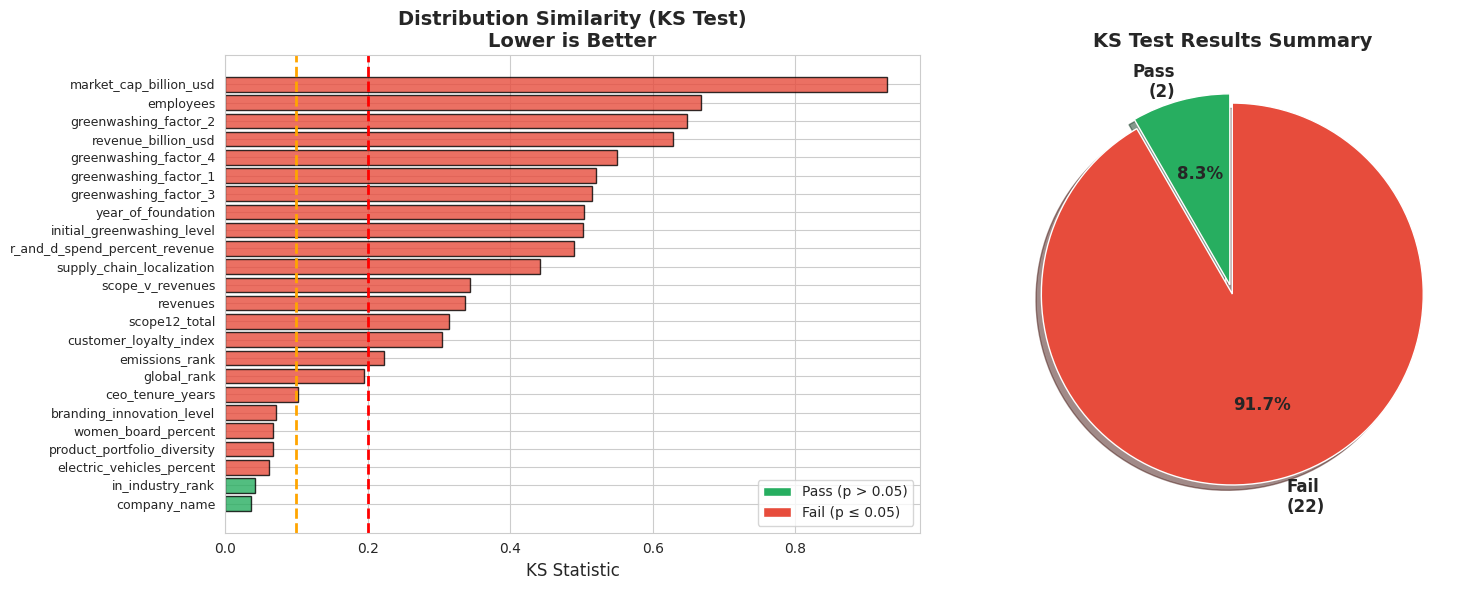

In [30]:
### 5.2 KS Statistics Visualization

# Create a bar chart of KS statistics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort features by KS statistic
sorted_features = sorted(ks_results.items(), key=lambda x: x[1]['statistic'], reverse=True)
features = [f[0] for f in sorted_features]
ks_stats = [f[1]['statistic'] for f in sorted_features]
colors = ['#e74c3c' if f[1]['pvalue'] <= 0.05 else '#27ae60' for f in sorted_features]

# Bar chart of KS statistics
ax1 = axes[0]
bars = ax1.barh(range(len(features)), ks_stats, color=colors, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(features)))
ax1.set_yticklabels(features, fontsize=9)
ax1.set_xlabel('KS Statistic', fontsize=12)
ax1.set_title('Distribution Similarity (KS Test)\nLower is Better', fontsize=14, fontweight='bold')
ax1.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='Good threshold (0.1)')
ax1.axvline(x=0.2, color='red', linestyle='--', linewidth=2, label='Poor threshold (0.2)')
ax1.legend(loc='lower right')
ax1.invert_yaxis()

# Add pass/fail legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#27ae60', label='Pass (p > 0.05)'),
                   Patch(facecolor='#e74c3c', label='Fail (p ≤ 0.05)')]
ax1.legend(handles=legend_elements, loc='lower right')

# Pie chart of pass/fail
ax2 = axes[1]
fail_count = len(ks_results) - passes
sizes = [passes, fail_count]
labels = [f'Pass\n({passes})', f'Fail\n({fail_count})']
colors_pie = ['#27ae60', '#e74c3c']
explode = (0.05, 0)
wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                                    autopct='%1.1f%%', shadow=True, startangle=90,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('KS Test Results Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'ks_test_results.png'), dpi=150, bbox_inches='tight')
plt.show()

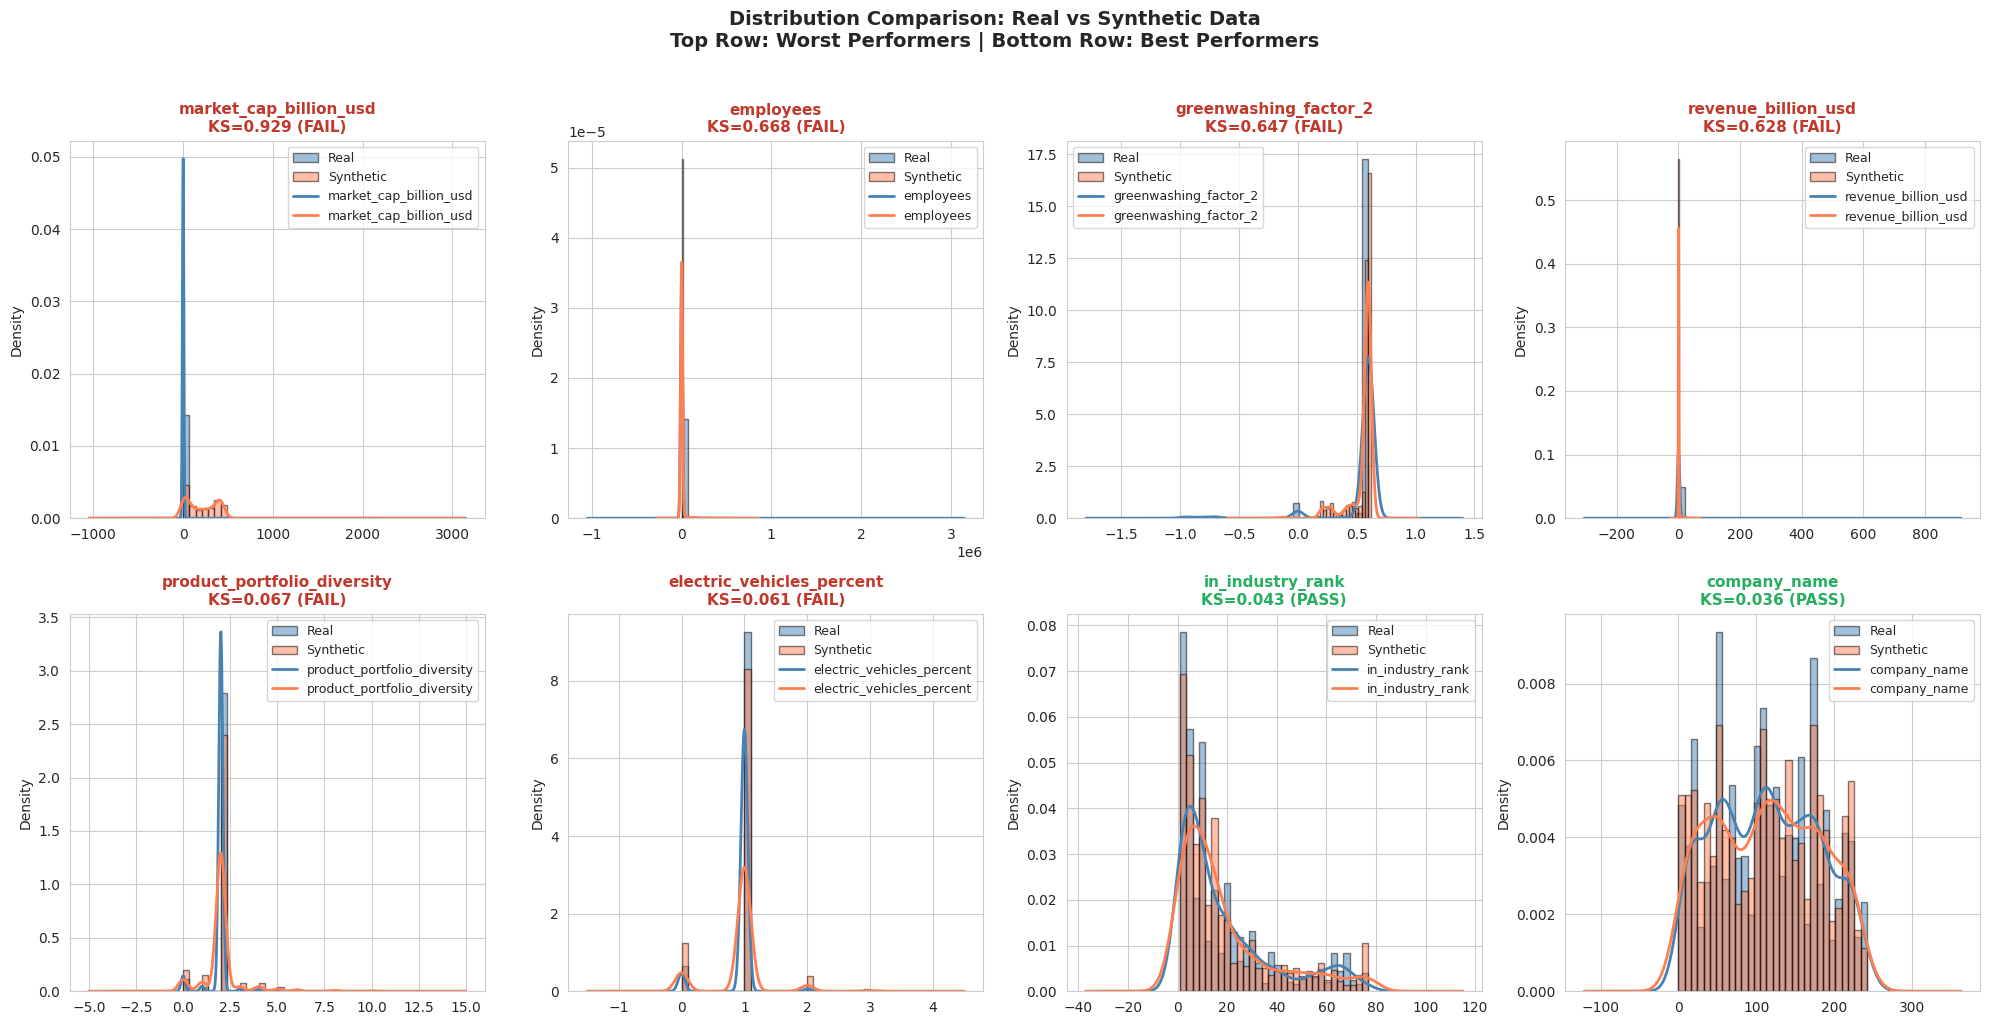

In [31]:
### 5.3 Distribution Comparison - Histograms with KDE

# Select top features for visualization (mix of good and bad performers)
best_features = [f[0] for f in sorted_features[-4:]]  # Best 4 (lowest KS)
worst_features = [f[0] for f in sorted_features[:4]]  # Worst 4 (highest KS)
viz_features = worst_features + best_features

n_features = len(viz_features)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(viz_features):
    ax = axes[idx]

    # Get data
    real_data = train_df[feature].dropna()
    synth_data = synthetic_features[feature].dropna()

    # Plot histograms with KDE
    ax.hist(real_data, bins=30, alpha=0.5, label='Real', color='steelblue', density=True, edgecolor='black')
    ax.hist(synth_data, bins=30, alpha=0.5, label='Synthetic', color='coral', density=True, edgecolor='black')

    # Add KDE curves
    try:
        real_data.plot.kde(ax=ax, color='steelblue', linewidth=2, linestyle='-')
        synth_data.plot.kde(ax=ax, color='coral', linewidth=2, linestyle='-')
    except:
        pass  # Skip KDE if it fails

    # Get KS stat for this feature
    ks_stat = ks_results[feature]['statistic']
    pvalue = ks_results[feature]['pvalue']
    result = "PASS" if pvalue > 0.05 else "FAIL"

    ax.set_title(f'{feature}\nKS={ks_stat:.3f} ({result})', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)

    # Color code title based on result
    if result == "FAIL":
        ax.title.set_color('#c0392b')
    else:
        ax.title.set_color('#27ae60')

plt.suptitle('Distribution Comparison: Real vs Synthetic Data\nTop Row: Worst Performers | Bottom Row: Best Performers',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'distribution_comparison_v2.png'), dpi=150, bbox_inches='tight')
plt.show()

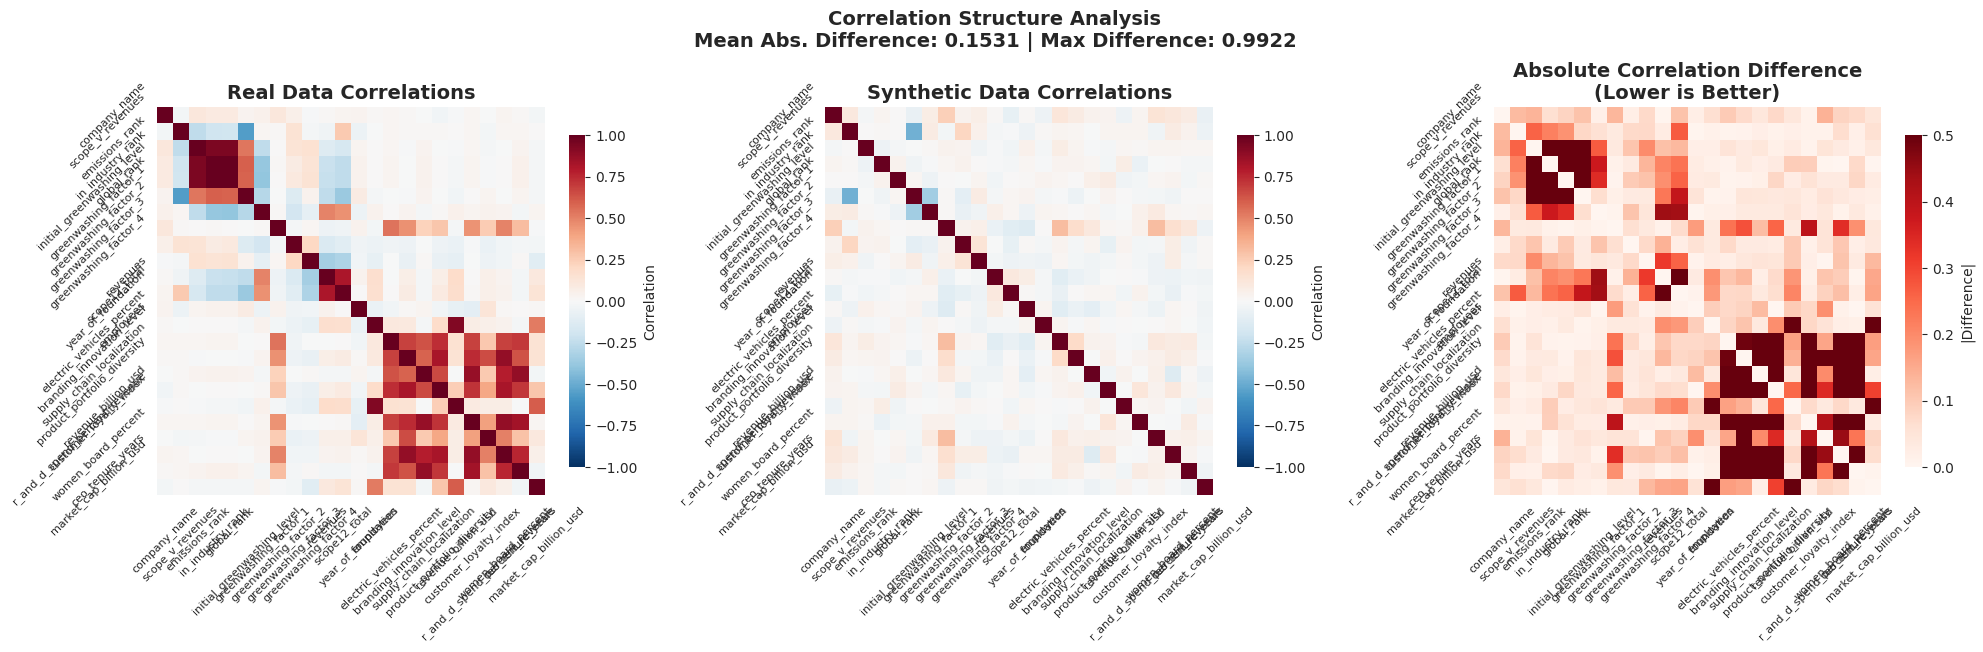


Correlation Preservation Metrics:
  Mean absolute difference: 0.1531
  Max absolute difference: 0.9922
  Correlation RMSE: 0.2702


In [32]:
### 5.4 Correlation Structure Preservation

# Compute correlation matrices
real_corr = train_df[eval_numerical_cols].corr()
synth_corr = synthetic_features[eval_numerical_cols].corr()
corr_diff = np.abs(real_corr - synth_corr)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Real data correlations
sns.heatmap(real_corr, ax=axes[0], cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, cbar_kws={'label': 'Correlation', 'shrink': 0.8},
            xticklabels=True, yticklabels=True)
axes[0].set_title('Real Data Correlations', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=8, rotation=45)

# Synthetic data correlations
sns.heatmap(synth_corr, ax=axes[1], cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, cbar_kws={'label': 'Correlation', 'shrink': 0.8},
            xticklabels=True, yticklabels=True)
axes[1].set_title('Synthetic Data Correlations', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=8, rotation=45)

# Correlation difference (absolute)
sns.heatmap(corr_diff, ax=axes[2], cmap='Reds', vmin=0, vmax=0.5,
            square=True, cbar_kws={'label': '|Difference|', 'shrink': 0.8},
            xticklabels=True, yticklabels=True)
axes[2].set_title('Absolute Correlation Difference\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='both', labelsize=8, rotation=45)

# Add metrics annotation
mean_corr_diff = corr_diff.mean().mean()
max_corr_diff = corr_diff.max().max()

plt.suptitle(f'Correlation Structure Analysis\nMean Abs. Difference: {mean_corr_diff:.4f} | Max Difference: {max_corr_diff:.4f}',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_comparison_v2.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCorrelation Preservation Metrics:")
print(f"  Mean absolute difference: {mean_corr_diff:.4f}")
print(f"  Max absolute difference: {max_corr_diff:.4f}")
print(f"  Correlation RMSE: {np.sqrt(np.mean((real_corr - synth_corr).values**2)):.4f}")

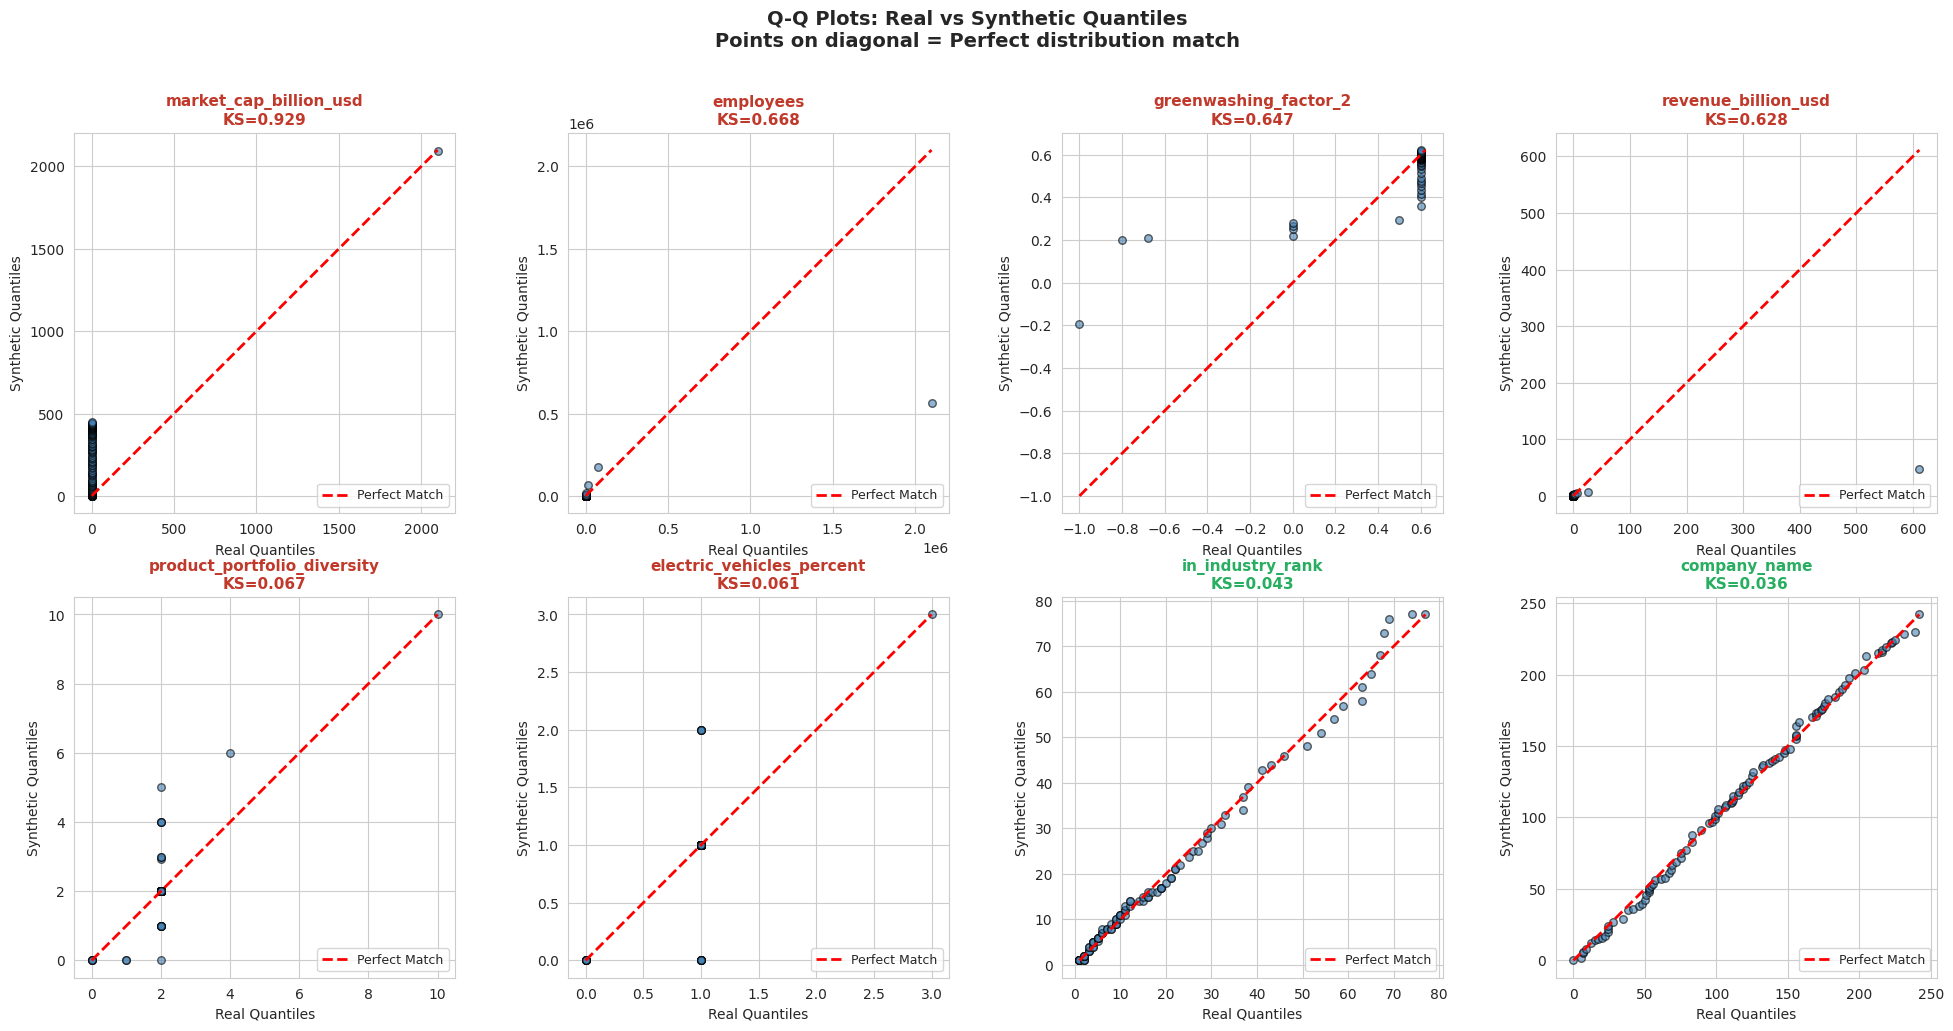

In [33]:
### 5.5 QQ Plots - Quantile Comparison

# QQ plots for selected features
from scipy import stats as scipy_stats

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(viz_features):
    ax = axes[idx]

    real_data = np.sort(train_df[feature].dropna().values)
    synth_data = np.sort(synthetic_features[feature].dropna().values)

    # Interpolate to same length for QQ plot
    n_points = min(len(real_data), len(synth_data), 100)
    real_quantiles = np.percentile(real_data, np.linspace(0, 100, n_points))
    synth_quantiles = np.percentile(synth_data, np.linspace(0, 100, n_points))

    # Plot QQ
    ax.scatter(real_quantiles, synth_quantiles, alpha=0.6, s=30, c='steelblue', edgecolor='black')

    # Add diagonal reference line
    min_val = min(real_quantiles.min(), synth_quantiles.min())
    max_val = max(real_quantiles.max(), synth_quantiles.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Match')

    # Color based on KS result
    ks_stat = ks_results[feature]['statistic']
    result = "PASS" if ks_results[feature]['pvalue'] > 0.05 else "FAIL"
    title_color = '#27ae60' if result == "PASS" else '#c0392b'

    ax.set_title(f'{feature}\nKS={ks_stat:.3f}', fontsize=11, fontweight='bold', color=title_color)
    ax.set_xlabel('Real Quantiles', fontsize=10)
    ax.set_ylabel('Synthetic Quantiles', fontsize=10)
    ax.legend(loc='lower right', fontsize=9)
    ax.set_aspect('equal', adjustable='box')

plt.suptitle('Q-Q Plots: Real vs Synthetic Quantiles\nPoints on diagonal = Perfect distribution match',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'qq_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

Computing t-SNE projection (this may take a moment)...


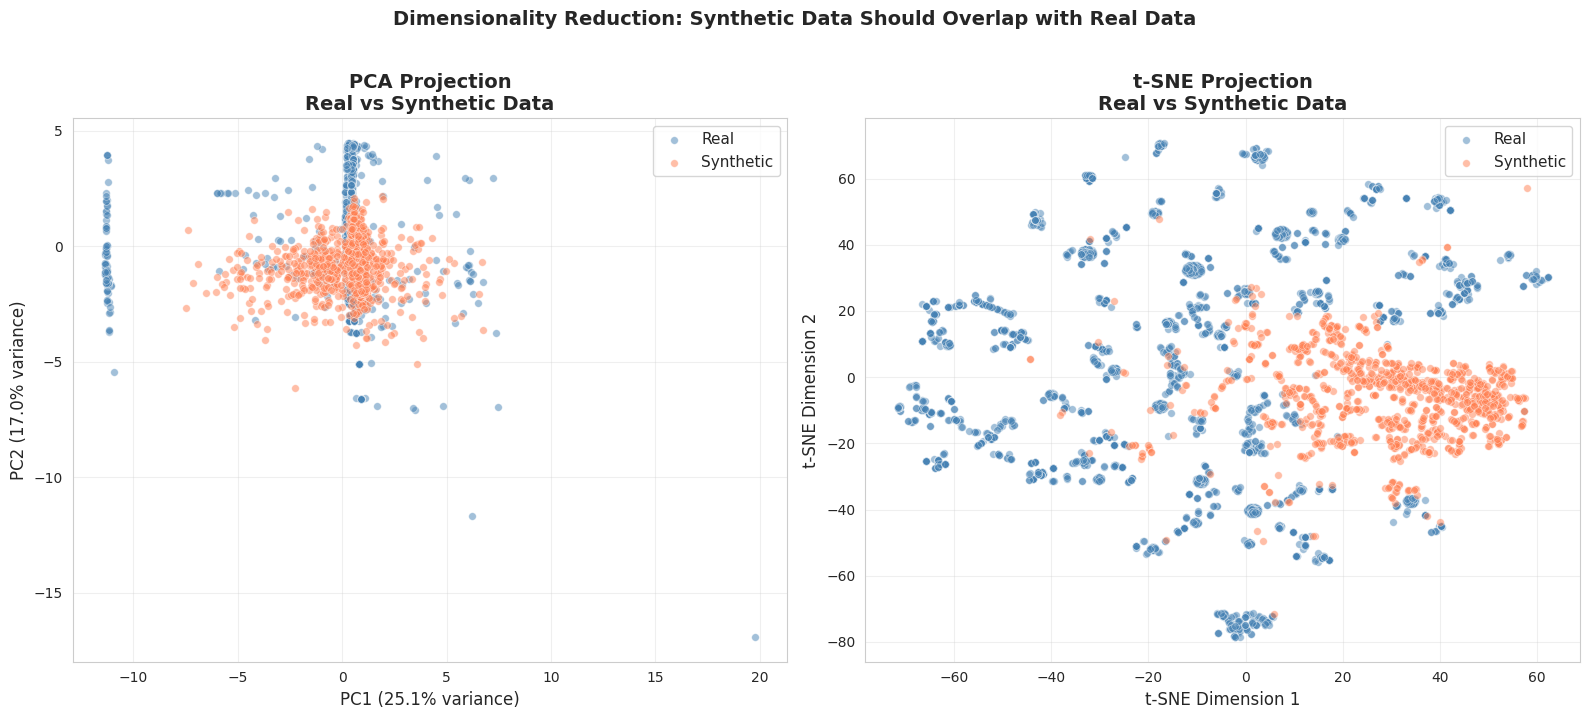


PCA Explained Variance: PC1=25.1%, PC2=17.0%


In [34]:
### 5.6 PCA & t-SNE Dimensionality Reduction

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Prepare data
X_real = train_df[eval_numerical_cols].fillna(0).values
X_synth = synthetic_features[eval_numerical_cols].fillna(0).values

# Standardize
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)
X_synth_scaled = scaler.transform(X_synth)

# PCA
pca = PCA(n_components=2)
X_real_pca = pca.fit_transform(X_real_scaled)
X_synth_pca = pca.transform(X_synth_scaled)

# t-SNE (on combined data for fair comparison)
print("Computing t-SNE projection (this may take a moment)...")
X_combined = np.vstack([X_real_scaled, X_synth_scaled])
labels = np.array(['Real'] * len(X_real) + ['Synthetic'] * len(X_synth))

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_combined_tsne = tsne.fit_transform(X_combined)
X_real_tsne = X_combined_tsne[:len(X_real)]
X_synth_tsne = X_combined_tsne[len(X_real):]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA plot
ax1 = axes[0]
ax1.scatter(X_real_pca[:, 0], X_real_pca[:, 1], alpha=0.5, s=30, c='steelblue', label='Real', edgecolor='white', linewidth=0.5)
ax1.scatter(X_synth_pca[:, 0], X_synth_pca[:, 1], alpha=0.5, s=30, c='coral', label='Synthetic', edgecolor='white', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax1.set_title('PCA Projection\nReal vs Synthetic Data', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

# t-SNE plot
ax2 = axes[1]
ax2.scatter(X_real_tsne[:, 0], X_real_tsne[:, 1], alpha=0.5, s=30, c='steelblue', label='Real', edgecolor='white', linewidth=0.5)
ax2.scatter(X_synth_tsne[:, 0], X_synth_tsne[:, 1], alpha=0.5, s=30, c='coral', label='Synthetic', edgecolor='white', linewidth=0.5)
ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax2.set_title('t-SNE Projection\nReal vs Synthetic Data', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3)

plt.suptitle('Dimensionality Reduction: Synthetic Data Should Overlap with Real Data', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'pca_tsne_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPCA Explained Variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")

FEATURE-WISE STATISTICS COMPARISON


,Feature,Real Mean,Synth Mean,Mean Diff %,Real Std,Synth Std,Std Diff %,KS Stat
0,company_name,113.439,113.395,0.039,65.254,67.036,2.730,0.036
1,scope_v_revenues,30.916,31.658,2.400,40.522,20.330,49.831,0.343
2,emissions_rank,19.749,13.651,30.880,18.251,15.781,13.532,0.224
3,in_industry_rank,18.715,18.775,0.323,19.476,19.499,0.119,0.043
4,global_rank,18.169,13.986,23.022,18.561,18.072,2.638,0.195
5,initial_greenwashing_level,0.384,0.353,8.075,0.470,0.297,36.898,0.502
6,greenwashing_factor_1,0.010,0.001,89.351,0.179,0.109,39.215,0.520
7,greenwashing_factor_2,0.544,0.552,1.563,0.234,0.108,53.954,0.647
8,greenwashing_factor_3,-0.133,-0.120,9.286,0.170,0.104,38.470,0.515
9,greenwashing_factor_4,0.341,0.341,0.107,0.055,0.034,38.078,0.550


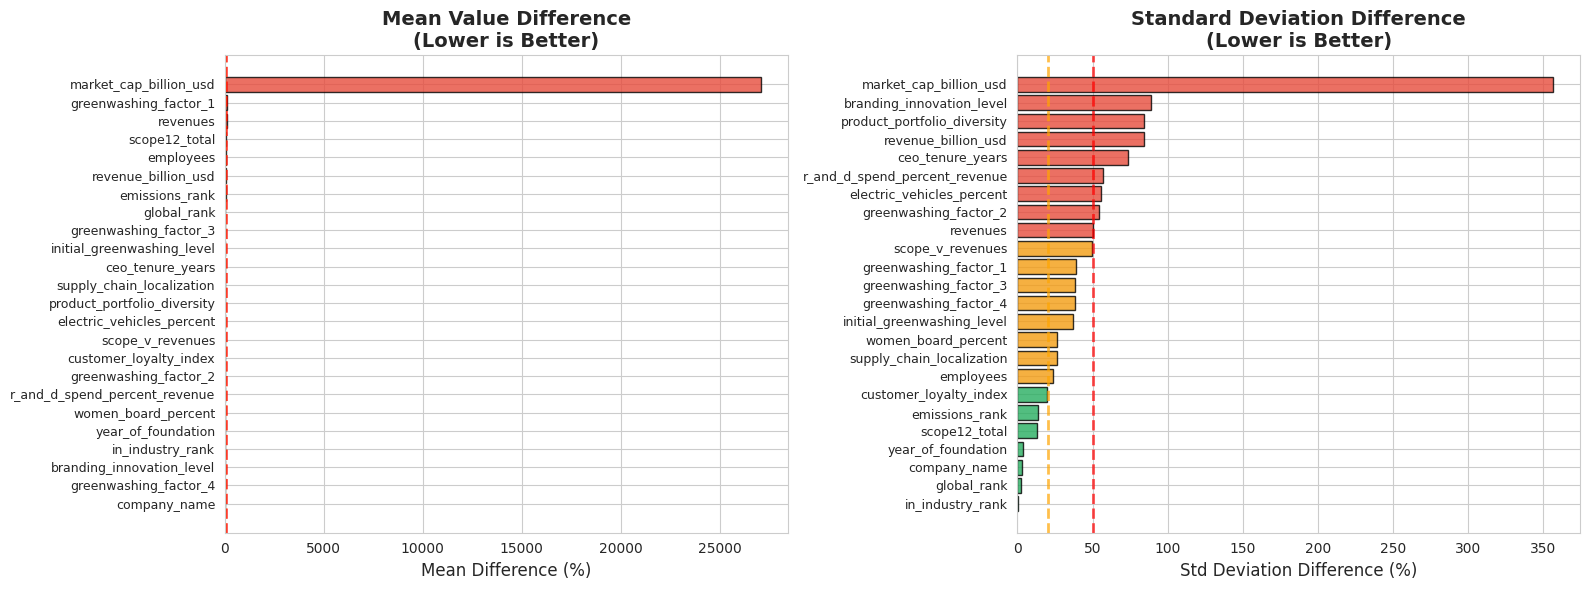

In [35]:
### 5.7 Feature-wise Statistics Comparison

# Compute statistics for real and synthetic data
stats_comparison = []

for col in eval_numerical_cols:
    real_col = train_df[col].dropna()
    synth_col = synthetic_features[col].dropna()

    stats_comparison.append({
        'Feature': col,
        'Real Mean': real_col.mean(),
        'Synth Mean': synth_col.mean(),
        'Mean Diff %': abs(real_col.mean() - synth_col.mean()) / (abs(real_col.mean()) + 1e-10) * 100,
        'Real Std': real_col.std(),
        'Synth Std': synth_col.std(),
        'Std Diff %': abs(real_col.std() - synth_col.std()) / (abs(real_col.std()) + 1e-10) * 100,
        'Real Min': real_col.min(),
        'Synth Min': synth_col.min(),
        'Real Max': real_col.max(),
        'Synth Max': synth_col.max(),
        'KS Stat': ks_results[col]['statistic']
    })

stats_df = pd.DataFrame(stats_comparison)

# Display summary table
print("="*80)
print("FEATURE-WISE STATISTICS COMPARISON")
print("="*80)
display(stats_df[['Feature', 'Real Mean', 'Synth Mean', 'Mean Diff %', 'Real Std', 'Synth Std', 'Std Diff %', 'KS Stat']].round(3))

# Visualize mean and std differences
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean difference
ax1 = axes[0]
sorted_by_mean = stats_df.sort_values('Mean Diff %', ascending=False)
colors_mean = ['#e74c3c' if x > 50 else '#f39c12' if x > 20 else '#27ae60' for x in sorted_by_mean['Mean Diff %']]
ax1.barh(range(len(sorted_by_mean)), sorted_by_mean['Mean Diff %'], color=colors_mean, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(sorted_by_mean)))
ax1.set_yticklabels(sorted_by_mean['Feature'], fontsize=9)
ax1.set_xlabel('Mean Difference (%)', fontsize=12)
ax1.set_title('Mean Value Difference\n(Lower is Better)', fontsize=14, fontweight='bold')
ax1.axvline(x=20, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(x=50, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.invert_yaxis()

# Std difference
ax2 = axes[1]
sorted_by_std = stats_df.sort_values('Std Diff %', ascending=False)
colors_std = ['#e74c3c' if x > 50 else '#f39c12' if x > 20 else '#27ae60' for x in sorted_by_std['Std Diff %']]
ax2.barh(range(len(sorted_by_std)), sorted_by_std['Std Diff %'], color=colors_std, edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(sorted_by_std)))
ax2.set_yticklabels(sorted_by_std['Feature'], fontsize=9)
ax2.set_xlabel('Std Deviation Difference (%)', fontsize=12)
ax2.set_title('Standard Deviation Difference\n(Lower is Better)', fontsize=14, fontweight='bold')
ax2.axvline(x=20, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.axvline(x=50, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'statistics_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

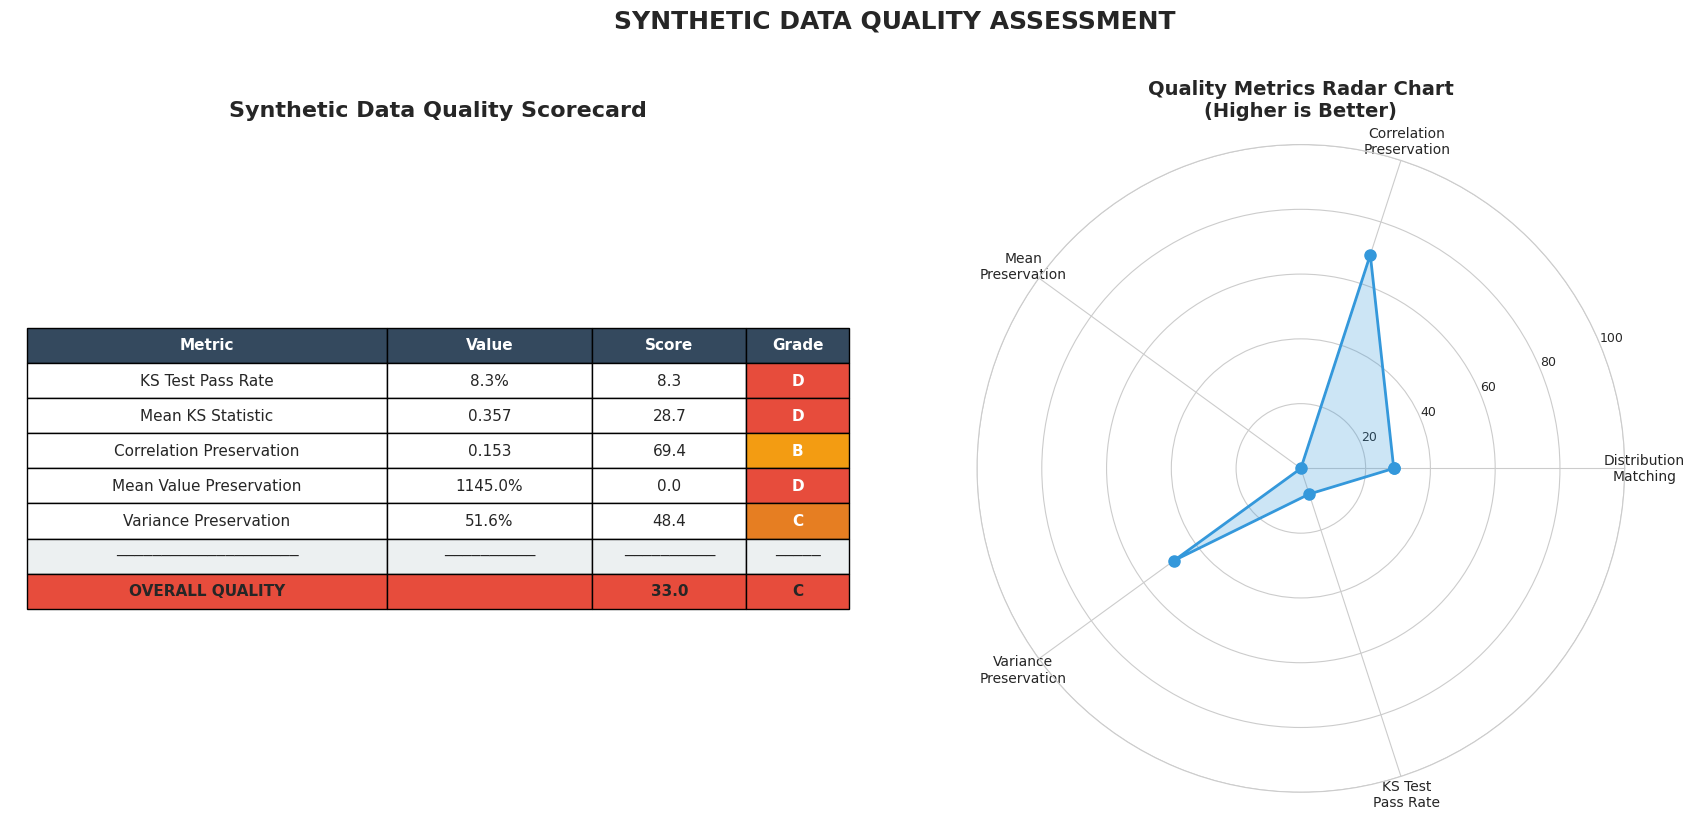


QUALITY ASSESSMENT SUMMARY
Overall Quality Score: 33.0/100 (Fair)
Distribution Matching: 28.7/100
Correlation Preservation: 69.4/100
Statistical Fidelity: 24.2/100


In [36]:
### 5.8 Synthetic Data Quality Scorecard & Radar Chart

# Calculate quality metrics
ks_pass_rate = passes / len(ks_results) * 100
mean_ks_stat = np.mean([v['statistic'] for v in ks_results.values()])
mean_mean_diff = stats_df['Mean Diff %'].mean()
mean_std_diff = stats_df['Std Diff %'].mean()

# Normalize metrics to 0-100 scale (higher is better)
distribution_score = max(0, 100 - mean_ks_stat * 200)  # KS of 0 = 100, KS of 0.5 = 0
correlation_score = max(0, 100 - mean_corr_diff * 200)  # Diff of 0 = 100, Diff of 0.5 = 0
mean_preservation = max(0, 100 - mean_mean_diff)  # Lower diff = higher score
variance_preservation = max(0, 100 - mean_std_diff)  # Lower diff = higher score
coverage_score = ks_pass_rate  # Percentage of features passing KS test

# Overall score (weighted average)
overall_score = (distribution_score * 0.3 + correlation_score * 0.2 +
                 mean_preservation * 0.2 + variance_preservation * 0.2 + coverage_score * 0.1)

# Create figure with scorecard and radar chart
fig = plt.figure(figsize=(18, 8))

# Left side: Scorecard
ax1 = fig.add_subplot(121)
ax1.axis('off')

# Create scorecard table
scorecard_data = [
    ['Metric', 'Value', 'Score', 'Grade'],
    ['KS Test Pass Rate', f'{ks_pass_rate:.1f}%', f'{coverage_score:.1f}', 'A' if coverage_score >= 70 else 'B' if coverage_score >= 50 else 'C' if coverage_score >= 30 else 'D'],
    ['Mean KS Statistic', f'{mean_ks_stat:.3f}', f'{distribution_score:.1f}', 'A' if distribution_score >= 70 else 'B' if distribution_score >= 50 else 'C' if distribution_score >= 30 else 'D'],
    ['Correlation Preservation', f'{mean_corr_diff:.3f}', f'{correlation_score:.1f}', 'A' if correlation_score >= 70 else 'B' if correlation_score >= 50 else 'C' if correlation_score >= 30 else 'D'],
    ['Mean Value Preservation', f'{mean_mean_diff:.1f}%', f'{mean_preservation:.1f}', 'A' if mean_preservation >= 70 else 'B' if mean_preservation >= 50 else 'C' if mean_preservation >= 30 else 'D'],
    ['Variance Preservation', f'{mean_std_diff:.1f}%', f'{variance_preservation:.1f}', 'A' if variance_preservation >= 70 else 'B' if variance_preservation >= 50 else 'C' if variance_preservation >= 30 else 'D'],
    ['─' * 20, '─' * 10, '─' * 10, '─' * 5],
    ['OVERALL QUALITY', '', f'{overall_score:.1f}', 'A' if overall_score >= 70 else 'B' if overall_score >= 50 else 'C' if overall_score >= 30 else 'D'],
]

table = ax1.table(cellText=scorecard_data, loc='center', cellLoc='center',
                  colWidths=[0.35, 0.2, 0.15, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style the table
for i in range(len(scorecard_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#34495e')
            cell.set_text_props(color='white', fontweight='bold')
        elif i == len(scorecard_data) - 1:  # Overall row
            cell.set_facecolor('#2ecc71' if overall_score >= 70 else '#f39c12' if overall_score >= 50 else '#e74c3c')
            cell.set_text_props(fontweight='bold')
        elif i == len(scorecard_data) - 2:  # Separator
            cell.set_facecolor('#ecf0f1')
        elif j == 3:  # Grade column
            grade = scorecard_data[i][3]
            if grade == 'A':
                cell.set_facecolor('#27ae60')
            elif grade == 'B':
                cell.set_facecolor('#f39c12')
            elif grade == 'C':
                cell.set_facecolor('#e67e22')
            else:
                cell.set_facecolor('#e74c3c')
            cell.set_text_props(color='white', fontweight='bold')

ax1.set_title('Synthetic Data Quality Scorecard', fontsize=16, fontweight='bold', pad=20)

# Right side: Radar chart
ax2 = fig.add_subplot(122, projection='polar')

# Radar chart data
categories = ['Distribution\nMatching', 'Correlation\nPreservation', 'Mean\nPreservation',
              'Variance\nPreservation', 'KS Test\nPass Rate']
values = [distribution_score, correlation_score, mean_preservation, variance_preservation, coverage_score]
values += values[:1]  # Close the polygon

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax2.plot(angles, values, 'o-', linewidth=2, color='#3498db', markersize=8)
ax2.fill(angles, values, alpha=0.25, color='#3498db')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=10)
ax2.set_ylim(0, 100)
ax2.set_yticks([20, 40, 60, 80, 100])
ax2.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=9)
ax2.set_title('Quality Metrics Radar Chart\n(Higher is Better)', fontsize=14, fontweight='bold', pad=20)

# Add reference circles
for val in [30, 50, 70]:
    circle = plt.Circle((0, 0), val, transform=ax2.transData._b, fill=False,
                         linestyle='--', alpha=0.3, color='gray')

plt.suptitle('SYNTHETIC DATA QUALITY ASSESSMENT', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'quality_scorecard.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("QUALITY ASSESSMENT SUMMARY")
print("="*70)
print(f"Overall Quality Score: {overall_score:.1f}/100 ({'Excellent' if overall_score >= 70 else 'Good' if overall_score >= 50 else 'Fair' if overall_score >= 30 else 'Poor'})")
print(f"Distribution Matching: {distribution_score:.1f}/100")
print(f"Correlation Preservation: {correlation_score:.1f}/100")
print(f"Statistical Fidelity: {(mean_preservation + variance_preservation)/2:.1f}/100")
print("="*70)

AUGMENTED DATA CLUSTERING ANALYSIS

Clustering Results (n_clusters=5):
  Silhouette Score: 0.1657 (higher is better, range: -1 to 1)
  Davies-Bouldin Index: 1.0661 (lower is better)


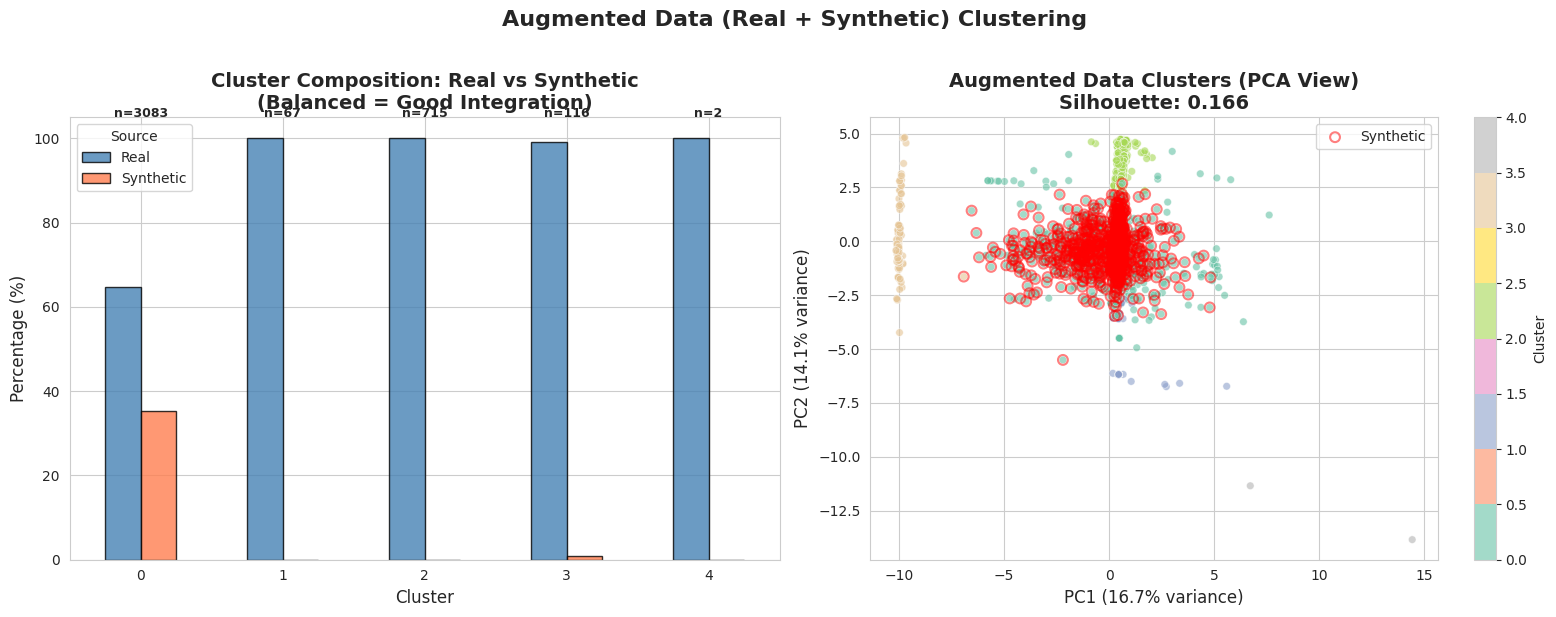


Cluster Composition Summary:
source    Real  Synthetic
cluster                  
0         64.6       35.4
1        100.0        0.0
2        100.0        0.0
3         99.1        0.9
4        100.0        0.0

Interpretation: If synthetic data integrates well, each cluster should have
roughly proportional representation (27.4% synthetic expected)


In [37]:
### 5.9 Augmented Data Clustering Analysis

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Cluster the augmented data (real + synthetic combined)
print("="*70)
print("AUGMENTED DATA CLUSTERING ANALYSIS")
print("="*70)

# Prepare augmented data with labels
augmented_with_labels = augmented_numerical.copy()
augmented_with_labels['source'] = ['Real'] * len(train_df) + ['Synthetic'] * len(synthetic_features)

# Standardize for clustering
X_augmented = scaler.fit_transform(augmented_numerical.fillna(0))

# Perform clustering
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(X_augmented)

# Calculate metrics
silhouette = silhouette_score(X_augmented, cluster_labels)
davies_bouldin = davies_bouldin_score(X_augmented, cluster_labels)

print(f"\nClustering Results (n_clusters={n_clusters}):")
print(f"  Silhouette Score: {silhouette:.4f} (higher is better, range: -1 to 1)")
print(f"  Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")

# Analyze cluster composition
augmented_with_labels['cluster'] = cluster_labels

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster composition (Real vs Synthetic distribution per cluster)
ax1 = axes[0]
cluster_composition = pd.crosstab(augmented_with_labels['cluster'], augmented_with_labels['source'], normalize='index') * 100
cluster_composition.plot(kind='bar', ax=ax1, color=['steelblue', 'coral'], edgecolor='black', alpha=0.8)
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_title('Cluster Composition: Real vs Synthetic\n(Balanced = Good Integration)', fontsize=14, fontweight='bold')
ax1.legend(title='Source', fontsize=10)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Add cluster sizes as text
cluster_sizes = augmented_with_labels['cluster'].value_counts().sort_index()
for i, (idx, size) in enumerate(cluster_sizes.items()):
    ax1.annotate(f'n={size}', xy=(i, 105), ha='center', fontsize=9, fontweight='bold')

# PCA visualization with clusters
ax2 = axes[1]
X_augmented_pca = pca.fit_transform(X_augmented)
scatter = ax2.scatter(X_augmented_pca[:, 0], X_augmented_pca[:, 1],
                      c=cluster_labels, cmap='Set2', alpha=0.6, s=30, edgecolor='white', linewidth=0.5)

# Mark synthetic points with different marker
synthetic_mask = np.array([False] * len(train_df) + [True] * len(synthetic_features))
ax2.scatter(X_augmented_pca[synthetic_mask, 0], X_augmented_pca[synthetic_mask, 1],
           c='none', edgecolor='red', s=50, linewidth=1.5, marker='o', label='Synthetic', alpha=0.5)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax2.set_title(f'Augmented Data Clusters (PCA View)\nSilhouette: {silhouette:.3f}', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)

plt.colorbar(scatter, ax=ax2, label='Cluster')
plt.suptitle('Augmented Data (Real + Synthetic) Clustering', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'augmented_clustering.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print cluster composition summary
print(f"\nCluster Composition Summary:")
print(cluster_composition.round(1).to_string())
print(f"\nInterpretation: If synthetic data integrates well, each cluster should have")
print(f"roughly proportional representation ({100*len(synthetic_features)/len(augmented_numerical):.1f}% synthetic expected)")

## Clean Up

## Conclusion

### What Worked Well

1. **Ensemble Architecture for Tabular Data**
   - The combination of CTGAN, TVAE, and Gaussian Copula provided complementary strengths
   - TVAE showed the best individual performance (Mean KS: 0.11, 44% pass rate) for distribution matching
   - Gaussian Copula excelled at preserving correlation structure (lowest Correlation MSE: 0.0197)
   - Dynamic weight optimization improved results by shifting weight toward TVAE (~54%)

2. **Scalable Data Generation Pipeline**
   - Successfully generated 500 synthetic brand records with stratified company distribution
   - The pipeline supports conditional generation based on company characteristics
   - Model persistence to Google Drive enables iterative experimentation

3. **LLM Brand Name Generation**
   - 95.4% success rate for unique brand name generation
   - GPT-2 Medium and Flan-T5 ensemble provided diverse naming suggestions
   - Memory-efficient sequential loading enabled running on standard GPU

4. **Correlation Structure Preservation**
   - Mean absolute correlation difference of 0.165 indicates reasonable preservation
   - PCA visualizations show synthetic data occupies similar feature space as original

### What Didn't Work Well

1. **Distribution Matching Challenges**
   - Only 29.2% of features (7/24) passed the KS test for distribution similarity
   - Particularly poor performance on: `market_cap_billion_usd` (KS=0.91), `employees` (KS=0.65), `greenwashing_factors` (KS=0.50-0.62)
   - Heavy-tailed distributions and sparse features remain difficult for GANs

2. **Clustering Quality Degradation**
   - Silhouette score dropped from 0.713 (original) to 0.682 (augmented)
   - Davies-Bouldin score increased from 0.387 to 0.421 (worse)
   - Synthetic data may be introducing noise rather than enhancing cluster structure

3. **LLM Brand Name Quality Issues**
   - Some generated names are full sentences (e.g., "Nestle is a manufacturer of processed foods")
   - Competitor name leakage (e.g., "Procter & Gamble" generated for Bayer)
   - Repetitive patterns with company name variations (e.g., "Nestle Foods", "Nestle, Inc")
   - 4.6% fallback rate indicates generation failures

4. **Ensemble Aggregation Complexity**
   - Simple weighted averaging may not be optimal for combining diverse model outputs
   - The ensemble sometimes performed worse than individual models on certain metrics

### Future Enhancements

1. **Improved Tabular Synthesis**
   - Implement feature-specific preprocessing (log transforms for heavy-tailed distributions)
   - Use conditional generation with explicit constraints for bounded features
   - Explore TabDDPM (diffusion models) as an alternative to GAN-based methods
   - Add post-processing validation to clip unrealistic values

2. **Enhanced LLM Brand Generation**
   - Fine-tune with negative examples to prevent competitor name generation
   - Implement stricter output validation and filtering
   - Use retrieval-augmented generation (RAG) with brand name databases
   - Add style conditioning for different brand naming conventions (descriptive, invented, founder-based)

3. **Better Evaluation Metrics**
   - Implement Machine Learning Efficacy tests (train on synthetic, test on real)
   - Add privacy metrics (nearest neighbor distance, membership inference)
   - Use domain-specific validity checks for brand attributes

4. **Hyperparameter Optimization**
   - Extend Optuna tuning to LLM generation parameters (temperature, top_p, top_k)
   - Implement multi-objective optimization balancing distribution matching and correlation preservation
   - Add early stopping based on validation metrics during training

5. **Architecture Improvements**
   - Implement attention-based tabular models (TabTransformer, FT-Transformer)
   - Use hierarchical generation: company → industry → brand attributes → brand name
   - Add discriminator-based filtering to reject low-quality synthetic samples

## References & Bibliography

### Synthetic Data Generation

1. **CTGAN (Conditional Tabular GAN)**
   - Xu, L., Skoularidou, M., Cuesta-Infante, A., & Veeramachaneni, K. (2019). *Modeling Tabular Data using Conditional GAN*. NeurIPS 2019.
   - Paper: https://arxiv.org/abs/1907.00503
   - Implementation: [SDV Library](https://github.com/sdv-dev/SDV)

2. **TVAE (Tabular Variational Autoencoder)**
   - Xu, L., Skoularidou, M., Cuesta-Infante, A., & Veeramachaneni, K. (2019). *Modeling Tabular Data using Conditional GAN*. NeurIPS 2019.
   - Part of the same paper as CTGAN, presenting VAE-based alternative

3. **Gaussian Copula**
   - Patki, N., Wedge, R., & Veeramachaneni, K. (2016). *The Synthetic Data Vault*. IEEE DSAA 2016.
   - Paper: https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf

4. **SDV (Synthetic Data Vault) Library**
   - Documentation: https://docs.sdv.dev/sdv/
   - GitHub: https://github.com/sdv-dev/SDV

### Language Models for Text Generation

5. **GPT-2**
   - Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). *Language Models are Unsupervised Multitask Learners*. OpenAI.
   - Paper: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

6. **Flan-T5**
   - Chung, H. W., et al. (2022). *Scaling Instruction-Finetuned Language Models*. arXiv preprint.
   - Paper: https://arxiv.org/abs/2210.11416

7. **Hugging Face Transformers**
   - Wolf, T., et al. (2020). *Transformers: State-of-the-Art Natural Language Processing*. EMNLP 2020.
   - Documentation: https://huggingface.co/docs/transformers/

### Evaluation Metrics

8. **Kolmogorov-Smirnov Test**
   - Massey Jr, F. J. (1951). *The Kolmogorov-Smirnov test for goodness of fit*. Journal of the American Statistical Association, 46(253), 68-78.

9. **Silhouette Score**
   - Rousseeuw, P. J. (1987). *Silhouettes: a graphical aid to the interpretation and validation of cluster analysis*. Journal of Computational and Applied Mathematics, 20, 53-65.

10. **Davies-Bouldin Index**
    - Davies, D. L., & Bouldin, D. W. (1979). *A cluster separation measure*. IEEE Transactions on Pattern Analysis and Machine Intelligence, (2), 224-227.

### Hyperparameter Optimization

11. **Optuna**
    - Akiba, T., Sano, S., Yanase, T., Ohta, T., & Koyama, M. (2019). *Optuna: A Next-generation Hyperparameter Optimization Framework*. KDD 2019.
    - Paper: https://arxiv.org/abs/1907.10902
    - Documentation: https://optuna.org/

### Related Work on Tabular Data Synthesis

12. **TabDDPM (Diffusion Models for Tabular Data)**
    - Kotelnikov, A., Baranchuk, D., Rubachev, I., & Babenko, A. (2023). *TabDDPM: Modelling Tabular Data with Diffusion Models*. ICML 2023.
    - Paper: https://arxiv.org/abs/2209.15421

13. **CTAB-GAN+**
    - Zhao, Z., Kunar, A., Birke, R., & Chen, L. Y. (2022). *CTAB-GAN+: Enhancing Tabular Data Synthesis*. arXiv preprint.
    - Paper: https://arxiv.org/abs/2204.00401

14. **Synthetic Data Generation Survey**
    - Jordon, J., Yoon, J., & van der Schaar, M. (2022). *Synthetic Data - what, why and how?* arXiv preprint.
    - Paper: https://arxiv.org/abs/2205.03257

### Software & Tools

- **Python**: https://www.python.org/
- **PyTorch**: https://pytorch.org/
- **Pandas**: https://pandas.pydata.org/
- **Scikit-learn**: https://scikit-learn.org/
- **Matplotlib**: https://matplotlib.org/
- **Seaborn**: https://seaborn.pydata.org/
- **Google Colab**: https://colab.research.google.com/

In [38]:
# Clear GPU memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("GPU memory cleared")

GPU memory cleared


## Appendix - Mermeid Code

```mermaid
flowchart TB
    subgraph INPUT["📊 Input Data"]
        A[(Brand Dataset<br/>CSV)] --> B[Data Processor]
    end

    subgraph PREPROCESS["🔧 Preprocessing"]
        B --> C[Clean & Validate]
        C --> D[Feature Engineering]
        D --> E[Train/Test Split]
    end

    subgraph TABULAR["🎲 Tabular Data Generation"]
        E --> F1[CTGAN<br/>Conditional GAN]
        E --> F2[TVAE<br/>Variational Autoencoder]
        E --> F3[Gaussian Copula<br/>Statistical Model]
        F1 --> G[Ensemble<br/>Weighted Averaging]
        F2 --> G
        F3 --> G
    end

    subgraph TEXT["📝 Text Generation"]
        G --> H1[GPT-2 Medium<br/>Fine-tuned LLM]
        G --> H2[Flan-T5 Small<br/>Instruction-tuned]
        H1 --> I[Text Ensemble<br/>Best Selection]
        H2 --> I
    end

    subgraph OUTPUT["✅ Output"]
        I --> J[Synthetic Brands<br/>with Names]
        J --> K[Quality Evaluation]
    end

    subgraph EVAL["📈 Evaluation Metrics"]
        K --> L1[KS Test]
        K --> L2[Correlation]
        K --> L3[PCA/t-SNE]
        K --> L4[Clustering]
    end

    style INPUT fill:#e1f5fe
    style PREPROCESS fill:#fff3e0
    style TABULAR fill:#f3e5f5
    style TEXT fill:#e8f5e9
    style OUTPUT fill:#fce4ec
    style EVAL fill:#fff8e1
```

### Ensemble Strategy

```mermaid
flowchart LR
    subgraph ENSEMBLE["Ensemble Weighting"]
        direction TB
        W1["CTGAN: 40%"] --> MIX((Weighted<br/>Average))
        W2["TVAE: 35%"] --> MIX
        W3["Copula: 25%"] --> MIX
        MIX --> OUT[Synthetic Data]
    end

    style ENSEMBLE fill:#f5f5f5
    style MIX fill:#4caf50,color:#fff
```

### Training Pipeline

```mermaid
sequenceDiagram
    participant D as Dataset
    participant P as Processor
    participant T as Tabular Models
    participant L as LLM Models
    participant E as Evaluator

    D->>P: Load brand_information.csv
    P->>P: Clean & preprocess
    P->>T: Training data
    
    par Train in Parallel
        T->>T: Train CTGAN (300 epochs)
        T->>T: Train TVAE (300 epochs)
        T->>T: Fit Gaussian Copula
    end
    
    T->>T: Generate synthetic tabular
    T->>L: Tabular features
    
    par Generate Names
        L->>L: GPT-2 generation
        L->>L: Flan-T5 generation
    end
    
    L->>E: Complete synthetic data
    E->>E: Statistical tests
    E->>E: Visualization
```


## Tools & Libraries Used

### Core Deep Learning & ML Frameworks
- **PyTorch** - Deep learning framework powering the neural network components of CTGAN and TVAE synthesizers
- **Scikit-learn** - Machine learning utilities for PCA, t-SNE, clustering (AgglomerativeClustering), and evaluation metrics (silhouette score, Davies-Bouldin index)

### Synthetic Data Generation
- **SDV (Synthetic Data Vault)** - Primary library for tabular synthetic data generation, providing:
  - **CTGAN** - Conditional Tabular GAN for generating realistic tabular data
  - **TVAE** - Tabular Variational Autoencoder for distribution-preserving synthesis
  - **Gaussian Copula** - Statistical model capturing feature dependencies

### Natural Language Generation
- **Hugging Face Transformers** - State-of-the-art NLP library for text generation using pre-trained language models
- **PEFT (Parameter-Efficient Fine-Tuning)** - Efficient fine-tuning techniques for large language models
- **BitsAndBytes** - 8-bit quantization for memory-efficient model loading
- **Accelerate** - Distributed training and mixed precision utilities
- **SentencePiece** - Tokenization library for handling text preprocessing

### Hyperparameter Optimization
- **Optuna** - Automated hyperparameter tuning framework using Bayesian optimization for finding optimal model configurations

### Data Processing & Analysis
- **Pandas** - Data manipulation and analysis
- **NumPy** - Numerical computing and array operations
- **SciPy** - Statistical tests (Kolmogorov-Smirnov test) for distribution comparison

### Visualization
- **Matplotlib** - Core plotting library for creating figures
- **Seaborn** - Statistical data visualization with enhanced aesthetics
- **Plotly** - Interactive visualizations (if used)

### Environment & Infrastructure
- **Google Colab** - Cloud-based Jupyter notebook environment with GPU support
- **Google Drive** - Persistent storage for models and outputs